#### __INFO 521__: _Introduction to Machine Learning_  $\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$  Jennifer Kadowaki
---

# Estimating Redshifts using Pixel Variations in Survey Images of Ultra-Diffuse Galaxies Candidates


## Introduction to Ultra-Diffuse Galaxies
Ultra-diffuse galaxies (UDGs)--an enigmatic population of spatially-extended, low surface-brightness galaxies--were recently discovered in large numbers (~1000) near the core of the Coma Cluster (Figure 1a). Despite their low stellar masses, UDGs survive in harsh and dense environments, implying that a subset of UDGs must reside in massive dark matter halos. To date, the largest and most massive UDG known is Dragonfly 44 (DF44; Figure 1b), which is as large as the Milky Way with only 1% of its stellar population. Based on scaling relations, globular cluster counts, and velocity dispersion measurements, the halo of DF44 is estimated to be as massive as the Milky Way’s, challenging our current framework on galaxy evolution: galaxies residing in dark matter halos of this mass regime are maximally efficient, typically producing 100x more stars (Figure 2). To remedy this discrepancy, we must understand what drives star formation in dark matter halos and why UDGs deviate so far from their expected star formation efficiency. My dissertation will (1) confirm the properties (e.g., size, mass) of UDGs to verify that this discrepancy is real and (2) test both large-scale and small-scale environmental mechanisms for halting star formation in UDGs.

UDGs in Coma  | DF44 Spectra
------------- | -------------
<img src="notebook_images/coma_all.png"/> | <img src="notebook_images/df44_spectra.png"/>
**Figure 1a**: The red dots highlight the locations of UDGs in the core of the Coma Galaxy Cluster. These UDGs initially discovered from a survey conducted with the Dragonfly Telephoto Array. The left image is a composite of the Dragonfly g+r bands. A higher resolution i-band image from the Canada-France-Hawaii Telescope (CFHT) confirms the presence of these galaxies.

**Figure 1b**: DF44 is the largest known UDG to date (until I publish my next paper). van Dokkum, et al. (2015b, 2016) confirms that this galaxy is indeed as large and as massive as the Milky Way by acquiring spectroscopic measurements with the Keck II Telescope.

<img src="notebook_images/behroozi13.png" alt="Evolution of Star Formation Efficiency" style="width: 800px;" align="center"/>
**Figure 2**: *The evolution of star formation efficiency across several orders of dark matter halo mass (Behroozi, et al. 2013).* Across most redshifts, the star formation efficiency appears to peak in galaxies residing in a $10^{12} \, \mathrm{M_{\odot}}$ dark matter halo--the Milky Way's estimated dark matter halo mass. If the population of massive UDGs are as massive as the Milky Way, our current understanding of galaxy evolution suggests that they should be extremely efficient at forming stars.


**Footnote**:
$1 \, \mathrm{M_{\odot}}$ (i.e. 1 "solar mass") corresponds to the mass of our Sun. The largest Milky Way dwarfs (i.e. Large and Small Magellanic Clouds) are roughly $10^{10} \, \mathrm{M_{\odot}}$. The Milky Way is considered to be a massive galaxy at $10^{12} \, \mathrm{M_{\odot}}$. Galaxies are often found in large clusterings of galaxies (i.e. galaxy clusters) with an estimated dynamical mass of $10^{14}-10^{15} \, \mathrm{M_{\odot}}$. These environments are extremely violent due to the strong gravitational interactions with other galaxies and the presence of the intercluster medium (ICM)--the extremely hot, x-ray emitting gas existing between clustered galaxies.

## Science Motivation
__What are the drivers of star formation in the dark matter halos of massive galaxies? Are environmental mechanisms responsible for star formation quenching in UDGs?__ To understand why massive UDGs deviate two orders of magnitude from their expected star formation efficiency and to identify potential environmental mechanisms causing this extreme quenching, we must obtain statistics of the local environments of UDGs. To do so, we must find more extremely massive UDGs across environments of various densities. This will require accurate distance measurements to (1) determine whether a candidate is a true UDG by confirming its physical size and (2) properly assess the environment of the UDG.


## INFO 521 Project Goal
Our group is conducting an extensive search throughout the DECaLS, BASS, and MzLS pre-imaging surveys to find large, spatially-extended, low-surface brightness (LSB) objects. So far, we have identified ~50 LSB targets for our next observational run at the Large Binocular Telescope in January 2018. However, as demonstrated in Kadowaki, et al. (in prep), by targeting the largest UDG candiates, our samples are contaminated by small foreground objects (e.g. large dwarf galaxies in the Local Group). __To maximize our efficiency at finding the largest and most massive UDGs for future galaxy evolution and dark matter studies, we must develop an algorithm to crudely estimate the redshifts of UDG candidates from available imaging data.__ We will use the results of this algorithm to select priority targets for our upcoming observation run. This notebook presents a preliminary analysis for our initiative, using machine learning methods.


## Methodology
Our UDG candidates are in proximity to the outskirts of the Coma Cluster. As such, a true UDG will more likely be at the redshift of the cluster. This distance is roughly ~100 Mpc (~326 million light years). For context, the distance to the Coma Cluster is roughly 100x the distance to the edge of the Local Group, where some of our dwarf galaxy contaminates reside. As such, UDGs appear as featureless "blobs." Due to the sheer distance, any structures or features in the UDG will appear washed out compared to our more local contaminants. I will exploit this known feature to help us determine UDG candidates from survery images.

I will use pixel variations as a proxy for clumpiness and structure in our images.

#### Importing Packages

In [1]:
%matplotlib inline

from astropy.io import fits
import glob as g
import errno
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import norm
import seaborn as sns
from sklearn.neighbors import KernelDensity
from skimage.measure import label, regionprops

# Turn off annoying matplotlib warning
import warnings
warnings.filterwarnings("ignore", ".*GUI is implemented.*")
warnings.filterwarnings("ignore", ".*LaTeX*")
warnings.filterwarnings("ignore", ".*clobber*")
warnings.filterwarnings("ignore", ".*Future*")

# Pretty Plot Text
plt.rcParams['savefig.facecolor'] = "1."
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)


In [2]:
# CONSTANTS
c  = 3.*10**5 # km/s                  # Speed of Light
H0 = 70 # (km/s)/Mpc                  # Hubble Constant
ARCSEC_IN_PIXEL  = 0.27               # DECam Plate Scale
ARCSEC_IN_RADIAN = 60*60*360/2/np.pi  # Radian to Arcsec Conversion
UDG_RADIUS       = 1.5 # kpc

#### File Name Convension

In [38]:
data_dir  = 'data'
im_dir    = 'images'

fits_file  = '.fits'
pdf_file   = '.pdf'
png_file   = '.png'

info_ext  = '.data'
model_ext = '_model'
sub_ext   = '_subtracted'
unsub_ext = '_unsubtracted'
mask_ext  = '_mask'
res_ext   = '_res'
hist_ext  = '_hist'
kde_ext   = '_kde'

obs_list  = []

#### Observation Class
This class stores file name information for all unique objects and observed bands.

In [40]:
class Observation:
    def __init__(self, UDG, band, info, model, sub, unsub):
        self.UDG   = UDG
        self.name  = UDG
        self.band  = band
        
        self.info  = info
        self.model = model
        self.sub   = sub
        self.unsub = unsub

        # Assign Values Later
        self.bkg_mean   = np.nan
        self.bkg_stdev  = np.nan
        self.gal_sma    = np.nan
        self.gal_mean   = np.nan
        self.gal_median = np.nan
        self.gal_stdev  = np.nan
        self.kde        = []
        
        self.mse          = np.nan
        self.velocity     = np.nan
        self.angular_size = np.nan
        self.radius_hlr   = np.nan
        self.radius_eff   = np.nan

        
    def get_info(self):
        return os.path.join(data_dir, self.UDG, self.band, self.info)

    def get_basename(self):
        return self.get_info()[:-5]
    
    def get_mask(self, mask=mask_ext, fits=fits_file):
        return self.get_basename() + mask + fits
    
    def get_model(self):
        return os.path.join(data_dir, self.UDG, self.band, self.model)
    
    def get_res(self, res=res_ext, fits=fits_file):
        return self.get_basename() + res + fits
    
    def get_sub(self):
        return os.path.join(data_dir, self.UDG, self.band, self.sub)
    
    def get_unsub(self):
        return os.path.join(data_dir, self.UDG, self.band, self.unsub)

#### Constructing New Obervation Objects based on Data Hierarchy
To run this code on the sample data provided, unpack data.zip in the same directory as this Jupyter notebook.

In [41]:
for obj_path in g.glob(data_dir + '/*'):
    
    obj = os.path.basename(obj_path)
    band_list = []
    print(obj)
    
    for band_path in g.glob(obj_path  + '/*'):
        
        band = os.path.basename(band_path)
        band_list.append(band)
        file_list = []
        print('\t',band)
        
        for file_path in g.glob(band_path + '/*'):
            
            file = os.path.basename(file_path)
            file_list.append(file)
            
            if info_ext in file_path:
                info = file
                print('\t\tINFO: ',file)

            if model_ext in file_path:
                model = file
                print('\t\tMODEL:',file)

            if sub_ext in file_path:
                sub = file
                print('\t\tSUB:  ',file)
                
            if unsub_ext in file_path:
                unsub = file
                print('\t\tUNSUB:',file)

        new_obs = Observation(obj, band, info, model, sub, unsub)
        obs_list.append(new_obs)

JenniferLBT.txt
PU0838589
	 g
		INFO:  PU0838589_260428_g.data
		MODEL: PU0838589_260428_g_model.fits
		SUB:   PU0838589_260428_g_subtracted.fits
		UNSUB: PU0838589_260428_g_unsubtracted.fits
	 z
		INFO:  PU0838589_260428_z.data
		MODEL: PU0838589_260428_z_model.fits
		SUB:   PU0838589_260428_z_subtracted.fits
		UNSUB: PU0838589_260428_z_unsubtracted.fits
PU0914401
	 g
		INFO:  PU0914401_283036_g.data
		MODEL: PU0914401_283036_g_model.fits
		SUB:   PU0914401_283036_g_subtracted.fits
		UNSUB: PU0914401_283036_g_unsubtracted.fits
	 z
		INFO:  PU0914401_283036_z.data
		MODEL: PU0914401_283036_z_model.fits
		SUB:   PU0914401_283036_z_subtracted.fits
		UNSUB: PU0914401_283036_z_unsubtracted.fits
PU1006233
	 z
		INFO:  PU1006233_285219_z.data
		MODEL: PU1006233_285219_z_model.fits
		SUB:   PU1006233_285219_z_subtracted.fits
		UNSUB: PU1006233_285219_z_unsubtracted.fits
	 z1
		INFO:  PU1006234_285219_z.data
		MODEL: PU1006234_285219_z_model.fits
		SUB:   PU1006234_285219_z_subtracted.fits
		U

#### Set Recessional Velocity & Effective Radius

In [42]:
for obs in obs_list:
    
    if obs.UDG == 'PU1302165':
        obs.name       = 'DF03'
        obs.velocity   = 10150
        obs.radius_eff = 4.2
        
    elif obs.UDG == 'PU1257017':
        obs.name       = 'DF07'
        obs.velocity   = 6587
        obs.radius_eff = 4.3
        
    elif obs.UDG == 'PU1301303':
        obs.name       = 'DF08'
        obs.velocity   = 7051
        obs.radius_eff = 4.4
        
    elif obs.UDG == 'PU1301582':
        obs.name       = 'DF17'
        obs.velocity   = np.nan
        obs.radius_eff = np.nan
        
    elif obs.UDG == 'PU1253151':
        obs.name       = 'DF30'
        obs.velocity   = 7316
        obs.radius_eff = 3.2
        
    elif obs.UDG == 'PU1258011':
        obs.name       = 'DF40'
        obs.velocity   = 7792
        obs.radius_eff = 2.9
        
    elif obs.UDG == 'PU0838589':
        obs.velocity   = np.nan
        obs.radius_eff = np.nan
        
    elif obs.UDG == 'PU0914401':
        obs.velocity   = 6558
        obs.radius_eff = 4.5
        
    elif obs.UDG == 'PU1006233':
        obs.velocity   = 1202
        obs.radius_eff = 0.7
        
    elif obs.UDG == 'PU1217378':
        obs.name       = 'PU1217377'
        obs.velocity   = 526
        obs.radius_eff = 0.5

    elif obs.UDG == 'PU1221086':
        obs.velocity   = 1287
        obs.radius_eff = 2.4
        
    elif obs.UDG == 'PU1224081':
        obs.velocity   = 37
        obs.radius_eff = 0.04
        
    elif obs.UDG == 'PU1251013':
        obs.velocity   = 6159
        obs.radius_eff = 4.3
        
    elif obs.UDG == 'PU1304535':
        obs.velocity   = 7333
        obs.radius_eff = 4.6
        
    else:
        obs.velocity   = np.nan
        obs.radius_eff = np.nan

### Functions for Organizing Data
The primary purpose for these functions is to keep consistent file names convensions and data hierarchy.
* create_directory(path)
* fname_split(path)

In [7]:
def create_directory(path):
    
    """Creates a new directory if one does not exist.

    Args:
        path (str): Name of directory

    Returns:
        N/A

    Raises:
        AttributeError: Blahblah
        ValueError: Blahblah.
    """
    
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [8]:
def fname_split(path):
    
    """Splits a pathname into a list of strings comprimsed of the directory name,
        the basename of the file, and the file extension.

    Example:
        >>> path = 'dir/fname.ext'
        >>> fname_split('dir/fname.ext')
            ['dir', 'fname', '.ext']

    Args:
        path (str): Name of path

    Returns:
        list: List of 3 strings containing directory, basename, and extension for a file.
              If a directory is called, the list returns empty strings for the basename and extension.
    """
    
    directory = os.path.dirname(path)
    base, ext = os.path.splitext(os.path.basename(path))
    
    return [directory, base, ext]

# DATA

PU0914401 (g) | PU0914401 (z) | Spectroscopy
------------- | ------------- | ------------
<img src="notebook_images/PU0914401_g.png"/> | <img src="notebook_images/PU0914401_z.png"/> | <img src="notebook_images/PU0914401_spec.png" style="width: 325px;"/>

**Figure 3ab**: The cleaned Dark Energy Survey (DES) g- and z-band images of PU0914401. This faint galaxy (at the center of the image) was initially found by applying wavelet transformations on DES survey images to identify  diffuse, spatially-extended sources.

**Figure 3c**: The spectrum of PU0914401 clearly features several Balmer and Ca II H&K absorption lines, as well as [OII] and [OIII] emission lines. Because we can match these features to their rest-frame wavelengths, we know how fast this object is travelling away from us due to the expansion rate of the universe. In the nearby universe, this recessional velocity linearly scales with the object's redshift. (Therefore, we will use recessional velocity ($cz$) synonymously with redshift ($z$) for the remainer of the notebook.)

## Spectroscopic Data from the Large Binocular Telescope (LBT)
We obtain accurate redshifts for UDG candidates by cross-correleating its spectra (Figure 3c) with stellar templates featuring absorption lines commonly found in UDGs. The Doppler shift (i.e. velocity offset) found between the UDG spectra and stellar templates correspond to a velocity attributed to the universe's expansion rate. From Hubble's law, we can determine the distances to these candidates. Given the known angular size of the galaxies, a higher redshift would imply a larger physical size. Table 1 lists the coordinates [RA (J2000), dec (J2000)], the recessional velocity, and the resulting effective radius for each UDG candidate from Kadowaki, et al. (2017) and Kadowaki, et al. (in prep). Of the 14 objects, we sucessfully acquired redshift estimates for 12 candidates.

We will use our spectroscopic redshift measurements in the latter half of the notebook.

 OBJECT   | RA (J2000) | dec (J2000) | $cz$ (km/s) | $R_\mathrm{eff}$ (kpc)
--------- | ---------- | ----------- | ----------- | ----------------------    
DF03      | 13:02:16.5 |  28:57:17   |    10150    | 4.2
DF07      | 12:57:01.7 |  28:23:25   |    6587     | 4.3
DF08      | 13:01:30.4 |  28:22:28   |    7051     | 4.4
DF17      | 13:01:58.3 |  27:50:11   |    ----     | ---
DF30      | 12:53:15.1 |  27:41:15   |    7316     | 3.2
DF40      | 12:58:01.1 |  27:11:26   |    7792     | 2.9
PU0838589 | 08:38:58.9 |  26:04:28   |    ----     | ---
PU0914401 | 09:14:40.1 |  28:30:36   |    6558     | 4.5
PU1006233 | 10:06:23.3 |  28:52:19   |    1202     | 0.7
PU1217377 | 12:17:37.7 |  28:35:20   |    526      | 0.5
PU1221086 | 12:21:08.6 |  29:29:21   |    1287     | 2.4
PU1224081 | 12:24:08.1 |  28:05:45   |    37       | 0.04
PU1251013 | 12:51:01.3 |  27:47:53   |    6159     | 4.3
PU1304535 | 13:04:53.5 |  27:42:53   |    7333     | 4.6

## Imaging Data from the Dark Energy Camera Legacy Survery (DECaLS)

Our imaging data for objects we have observed and for candidates we will be observing are from the DESI pre-imaging surveys. For most of our targets, we have at least two bands (g-, r-, and i-bands) for each object.

### Plotting Imaging Data
All imaging data from the UDG candidates observed in the past are included in data.zip.

In [9]:
def plot_image(im, sigma=3, data=None, plot_file=None, directory=None, shape=(200,200), verbose=False, show=False):

    """ Plots imaging data to a .pdf file.
    If data is not specified, data is acquired by reading in im. Otherwise, the data is written out to im.
    Plots data and writes out displayed image to plot_file in directory. If plot_file is not specified,
    the plot_file is taken from the basename of im with extension '.pdf'. If directory is not specified,
    the plot is written out to a new subdirectory 'images'.
    
    Args:
        im (str): Name of .fits file for (1) reading & importing data or (2) writing out data.
        
        data (:obj:`nd.array`, optional):
            Array containing imaging data. If set to None, the data is acquired by reading it from im,
            a pre-existing .fits file. If it contains an array, the data is written out to im.
        
        pdf_file (str): Name of .pdf file to display data.
        
        directory (str): Name of directory to save pdf_file.
        
    Returns:
        data (float).
        
    """
    
    d, b, e = fname_split(im)
    
    if directory == None:
        directory = d
        im_directory = os.path.join(d, im_dir)
    else:
        im_directory = os.path.join(directory, im_dir)
        
    create_directory(directory)
    create_directory(im_directory)
    
    if plot_file == None:
        plot_file = os.path.join(im_directory, b + pdf_file)

        
    if data == None:
        if verbose: print("\nReading", im, ".")
        data = fits.getdata(im)
        
        if data.shape != shape:
            data = data[0:shape[0],0:shape[1]]
            hdu = fits.PrimaryHDU(np.array(data))
            hdu.writeto(im, clobber=True)
            
    else:
        im = os.path.join(directory, b + fits_file)
        if verbose: print("\nWriting", im, ".")
        hdu = fits.PrimaryHDU(np.array(data[0:shape[0],0:shape[1]]))
        hdu.writeto(im, clobber=True)
    
    
    mean  = np.mean(data)
    std  = np.std(data)
    
    plt.clf()
    plt.figure(figsize=(8,8))
    
    plt.xlabel(r"x (Pixels)")
    plt.ylabel(r"y (Pixels)")
    plt.title(r"$\mathrm{}$".format("{" + b.replace("_","\_") + "}"))

    plt.imshow(data, interpolation='none', aspect='equal', cmap='inferno', vmin=mean-sigma*std, vmax=mean+sigma*std)
    plt.colorbar()
    ax = plt.gca()
    ax.grid(color='k', linestyle='-', linewidth=0.5)
    
    if verbose: print("Writing", plot_file, ".")
    plt.savefig(plot_file, format='pdf', bbox_inches='tight', dpi=72)
    plt.savefig(plot_file.replace(pdf_file, png_file), format='png', bbox_inches='tight')

    if show: plt.show()
    plt.close()
    
    
    return data

#### Plots of all Observed UDG Candidates in Available DES Survey Bands with their Model & Residual Images

In [43]:
for obs in obs_list:
    
    data_unsub = plot_image(obs.get_unsub(), sigma=2)
    data_model = plot_image(obs.get_model(), sigma=10)
    data_ures  = plot_image(obs.get_res(), data=data_unsub-data_model, sigma=1)

## GALFIT Models & Residual Images
Each of the original images were fed into GALFIT--an astronomical software used to model and extract galaxies. The models were fit with parameters characterizing the effective radii (i.e. size), brightness, and sersic index (i.e. concentration of density profile) for each target.

The residual image is the difference between the original image and the GALFIT model. **We use the residual image to determine clumpiness via pixel intensity variations.**

|       | DF03 (g) | DF03 (r) | DF03 (z) | DF07 (g) | DF07 (r) | DF07 (z) |
| :---- | :------: | :------: | :------: | :------: | :------: | :------: |
| ORIG  | <img src="data/PU1302165/g/images/PU1302165_285718_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1302165/r/images/PU1302165_285718_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1302165/z/images/PU1302165_285718_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1257017/g/images/PU1257017_282325_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1257017/r/images/PU1257017_282325_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1257017/z/images/PU1257017_282325_z_unsubtracted.png" style="width: 150px;"/> | 
| MODEL | <img src="data/PU1302165/g/images/PU1302165_285718_g_model.png" style="width: 150px;"/> | <img src="data/PU1302165/r/images/PU1302165_285718_r_model.png" style="width: 150px;"/> | <img src="data/PU1302165/z/images/PU1302165_285718_z_model.png" style="width: 150px;"/> | <img src="data/PU1257017/g/images/PU1257017_282325_g_model.png" style="width: 150px;"/> | <img src="data/PU1257017/r/images/PU1257017_282325_r_model.png" style="width: 150px;"/> | <img src="data/PU1257017/z/images/PU1257017_282325_z_model.png" style="width: 150px;"/> |
| RES   | <img src="data/PU1302165/g/images/PU1302165_285718_g_res.png" style="width: 150px;"/> | <img src="data/PU1302165/r/images/PU1302165_285718_r_res.png" style="width: 150px;"/> | <img src="data/PU1302165/z/images/PU1302165_285718_z_res.png" style="width: 150px;"/> | <img src="data/PU1257017/g/images/PU1257017_282325_g_res.png" style="width: 150px;"/> | <img src="data/PU1257017/r/images/PU1257017_282325_r_res.png" style="width: 150px;"/> | <img src="data/PU1257017/z/images/PU1257017_282325_z_res.png" style="width: 150px;"/> |



|       | DF08 (g) | DF08 (r) | DF08 (z) | DF17 (g) | DF17 (r) | DF17 (z) |
| :---- | :------: | :------: | :------: | :------: | :------: | :------: |
| ORIG  | <img src="data/PU1301303/g/images/PU1301303_282229_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1301303/r/images/PU1301303_282229_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1301303/z/images/PU1301303_282229_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1301582/g/images/PU1301582_275011_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1301582/r/images/PU1301582_275011_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1301582/z/images/PU1301582_275011_z_unsubtracted.png" style="width: 150px;"/> | 
| MODEL | <img src="data/PU1301303/g/images/PU1301303_282229_g_model.png" style="width: 150px;"/> | <img src="data/PU1301303/r/images/PU1301303_282229_r_model.png" style="width: 150px;"/> | <img src="data/PU1301303/z/images/PU1301303_282229_z_model.png" style="width: 150px;"/> | <img src="data/PU1301582/g/images/PU1301582_275011_g_model.png" style="width: 150px;"/> | <img src="data/PU1301582/r/images/PU1301582_275011_r_model.png" style="width: 150px;"/> | <img src="data/PU1301582/z/images/PU1301582_275011_z_model.png" style="width: 150px;"/> |
| RES   | <img src="data/PU1301303/g/images/PU1301303_282229_g_res.png" style="width: 150px;"/> | <img src="data/PU1301303/r/images/PU1301303_282229_r_res.png" style="width: 150px;"/> | <img src="data/PU1301303/z/images/PU1301303_282229_z_res.png" style="width: 150px;"/> | <img src="data/PU1301582/g/images/PU1301582_275011_g_res.png" style="width: 150px;"/> | <img src="data/PU1301582/r/images/PU1301582_275011_r_res.png" style="width: 150px;"/> | <img src="data/PU1301582/z/images/PU1301582_275011_z_res.png" style="width: 150px;"/> |



|       | DF30 (g) | DF30 (z) | DF40 (g) | DF40 (r) | DF40 (z) |
| :---- | :------: | :------: | :------: | :------: | :------: |
| ORIG  | <img src="data/PU1253151/g/images/PU1253151_274116_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1253151/z/images/PU1253151_274116_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1258011/g/images/PU1258011_271126_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1258011/r/images/PU1258011_271126_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1258011/z/images/PU1258011_271126_z_unsubtracted.png" style="width: 150px;"/> | 
| MODEL | <img src="data/PU1253151/g/images/PU1253151_274116_g_model.png" style="width: 150px;"/> | <img src="data/PU1253151/z/images/PU1253151_274116_z_model.png" style="width: 150px;"/> | <img src="data/PU1258011/g/images/PU1258011_271126_g_model.png" style="width: 150px;"/> | <img src="data/PU1258011/r/images/PU1258011_271126_r_model.png" style="width: 150px;"/> | <img src="data/PU1258011/z/images/PU1258011_271126_z_model.png" style="width: 150px;"/> |
| RES   | <img src="data/PU1253151/g/images/PU1253151_274116_g_res.png" style="width: 150px;"/> | <img src="data/PU1253151/z/images/PU1253151_274116_z_res.png" style="width: 150px;"/> | <img src="data/PU1258011/g/images/PU1258011_271126_g_res.png" style="width: 150px;"/> | <img src="data/PU1258011/r/images/PU1258011_271126_r_res.png" style="width: 150px;"/> | <img src="data/PU1258011/z/images/PU1258011_271126_z_res.png" style="width: 150px;"/> |



|       | PU0838589 (g) | PU0838589 (z) | PU0914401 (g) | PU0914401 (z) | PU1006233 (z) | PU1006233 (z) |
| :---- | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |
| ORIG  | <img src="data/PU0838589/g/images/PU0838589_260428_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU0838589/z/images/PU0838589_260428_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU0914401/g/images/PU0914401_283036_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU0914401/z/images/PU0914401_283036_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1006233/z/images/PU1006233_285219_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1006233/z1/images/PU1006234_285219_z_unsubtracted.png" style="width: 150px;"/> | 
| MODEL | <img src="data/PU0838589/g/images/PU0838589_260428_g_model.png" style="width: 150px;"/> | <img src="data/PU0838589/z/images/PU0838589_260428_z_model.png" style="width: 150px;"/> | <img src="data/PU0914401/g/images/PU0914401_283036_g_model.png" style="width: 150px;"/> | <img src="data/PU0914401/z/images/PU0914401_283036_z_model.png" style="width: 150px;"/> | <img src="data/PU1006233/z/images/PU1006233_285219_z_model.png" style="width: 150px;"/> | <img src="data/PU1006233/z1/images/PU1006234_285219_z_model.png" style="width: 150px;"/> |
| RES   | <img src="data/PU0838589/g/images/PU0838589_260428_g_res.png" style="width: 150px;"/> | <img src="data/PU0838589/z/images/PU0838589_260428_z_res.png" style="width: 150px;"/> | <img src="data/PU0914401/g/images/PU0914401_283036_g_res.png" style="width: 150px;"/> | <img src="data/PU0914401/z/images/PU0914401_283036_z_res.png" style="width: 150px;"/> | <img src="data/PU1006233/z/images/PU1006233_285219_z_res.png" style="width: 150px;"/> | <img src="data/PU1006233/z1/images/PU1006234_285219_z_res.png" style="width: 150px;"/> |



|       | PU1217377 (g) | PU1217377 (r) | PU1217377 (z) | PU1221086 (z) | PU1224081 (g) | PU1224081 (r) | PU1224081 (z) |
| :---- | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |  :-----------: |
| ORIG  | <img src="data/PU1217378/g/images/PU1217378_283521_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1217378/r/images/PU1217378_283521_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1217378/z/images/PU1217378_283521_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1221086/z/images/PU1221086_292920_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1224081/g/images/PU1224081_280545_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1224081/r/images/PU1224081_280545_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1224081/z/images/PU1224081_280545_z_unsubtracted.png" style="width: 150px;"/> |
| MODEL | <img src="data/PU1217378/g/images/PU1217378_283521_g_model.png" style="width: 150px;"/> | <img src="data/PU1217378/r/images/PU1217378_283521_r_model.png" style="width: 150px;"/> | <img src="data/PU1217378/z/images/PU1217378_283521_z_model.png" style="width: 150px;"/> | <img src="data/PU1221086/z/images/PU1221086_292920_z_model.png" style="width: 150px;"/> | <img src="data/PU1224081/g/images/PU1224081_280545_g_model.png" style="width: 150px;"/> | <img src="data/PU1224081/r/images/PU1224081_280545_r_model.png" style="width: 150px;"/> | <img src="data/PU1224081/z/images/PU1224081_280545_z_model.png" style="width: 150px;"/> |
| RES   | <img src="data/PU1217378/g/images/PU1217378_283521_g_res.png" style="width: 150px;"/> | <img src="data/PU1217378/r/images/PU1217378_283521_r_res.png" style="width: 150px;"/> | <img src="data/PU1217378/z/images/PU1217378_283521_z_res.png" style="width: 150px;"/> | <img src="data/PU1221086/z/images/PU1221086_292920_z_res.png" style="width: 150px;"/> | <img src="data/PU1224081/g/images/PU1224081_280545_g_res.png" style="width: 150px;"/> | <img src="data/PU1224081/r/images/PU1224081_280545_r_res.png" style="width: 150px;"/> | <img src="data/PU1224081/z/images/PU1224081_280545_z_res.png" style="width: 150px;"/> |



|       | PU1251013 (g) | PU1251013 (r) | PU1251013 (z) | PU1304535 (g) | PU1304535 (r) | PU1304535 (z) |
| :---- | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |
| ORIG  | <img src="data/PU1251013/g/images/PU1251013_274753_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1251013/r/images/PU1251013_274753_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1251013/z/images/PU1251013_274753_z_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1304535/g/images/PU1304535_274253_g_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1304535/r/images/PU1304535_274253_r_unsubtracted.png" style="width: 150px;"/> | <img src="data/PU1304535/z/images/PU1304535_274253_z_unsubtracted.png" style="width: 150px;"/> |
| MODEL | <img src="data/PU1251013/g/images/PU1251013_274753_g_model.png" style="width: 150px;"/> | <img src="data/PU1251013/r/images/PU1251013_274753_r_model.png" style="width: 150px;"/> | <img src="data/PU1251013/z/images/PU1251013_274753_z_model.png" style="width: 150px;"/> | <img src="data/PU1304535/g/images/PU1304535_274253_g_model.png" style="width: 150px;"/> | <img src="data/PU1304535/r/images/PU1304535_274253_r_model.png" style="width: 150px;"/> | <img src="data/PU1304535/z/images/PU1304535_274253_z_model.png" style="width: 150px;"/> |
| RES   | <img src="data/PU1251013/g/images/PU1251013_274753_g_res.png" style="width: 150px;"/> | <img src="data/PU1251013/r/images/PU1251013_274753_r_res.png" style="width: 150px;"/> | <img src="data/PU1251013/z/images/PU1251013_274753_z_res.png" style="width: 150px;"/> | <img src="data/PU1304535/g/images/PU1304535_274253_g_res.png" style="width: 150px;"/> | <img src="data/PU1304535/r/images/PU1304535_274253_r_res.png" style="width: 150px;"/> | <img src="data/PU1304535/z/images/PU1304535_274253_z_res.png" style="width: 150px;"/> |

**Figure 4**: Observed UDG candidates with known spectroscopic redshifts.

__Tow Row__: The cleaned Dark Energy Survey (DES) images of UDG candidates. We discovered these faint galaxies (at the center of the image) by applying wavelet transformation on DES survey images to identify any diffuse, spatially-extended sources.

__Center Row__: The galaxy models were created using galfit, a common astronomy software used to estimate key galaxy model parameters.

__Bottom Row__: The difference image is the residual between the cleaned DES image and the model of the UDG. The model does a decent job at subtracting the overall profile of the galaxy. Any remaining structure within the difference image will be used to estimate redshift.

# Separating the UDG Candidate from the Background
Like most astronomical objects, there's no hard boundary between where the object starts and ends. (e.g. Where is the boundary of the our atmosphere? It's hard to define where it "stops.")

We define the half-light radius--a commonly used metric in extragalactic astronomy--as the radius which contains half of the object's light. To define this boundary, we typicaly use a true astronomical image. However, due to contamination from background objects (e.g. the bright source in the bottom left corner), we will use the model image (center) for the purpose of this project. The model contains a uniform background and a smooth sersic profile for the galaxy.

In [49]:
def background_statistics(obs, percent=40, plot=True, verbose=False):
    
    """Naively estimates the background statistics from model image.
    This algorithm assumes that any pixel value above some percentile (percent) has some light
    contribution from diffuse UDG candidates or other astronomical contaminants, as opposed to
    background noise from pixel-to-pixel variations. The method estimates the mean and standard
    deviation in pixel intensities within the identified background, primarily for the use to
    create more sophisticated object masks.
    
    
    Args:
        data (nd.array): Input image assumed to be a 2D array.
        
        percent (float): Percentile value assumed to be [0,100). All pixel intensities that
            fall below this percentile threshold is assumed to be the background.
            
        plot (bool): Flag to create a plot of the background mask.
        
    Returns:
        bkg_mean (float):  Mean value of background region.
        
        bkg_stdev (float): Standard deviation of the background region.
        
    """
    
    model = fits.getdata(obs.get_model())
    
    # Quick & Unsophisticated Statistics of UDG Candidate Models
    mini  = np.min(model)    # Min Value in the Model
    maxi  = np.max(model)    # Max
    mean  = np.mean(model)   # Mean
    stdev = np.std(model)    # Standard Deviation of Pixel Values

    if verbose:
        print("{0} ({1})".format(obs.name, obs.band))
        print("Global Image",
              "\n\tMEAN: ", mean,
              "\n\tSTD:  ", stdev,
              "\n\tMIN:  ", mini,
              "\n\tMAX:  ", maxi)

    # Image Statistics on Isolated Background
    bkg_mask      = np.array(model < np.percentile(model, percent))
    obs.bkg_mean  = np.mean(model[bkg_mask])
    obs.bkg_stdev = np.std(model[bkg_mask])

    if verbose:
        print("Background",
              "\n\tMean: %.3f" % obs.bkg_mean,
              "\n\tSTD:  %.3f" % obs.bkg_stdev)
    
    if plot:
        plot_bm = model * 1.
        plot_bm[~bkg_mask] = np.nan
        
        plt.figure(figsize=(5,5))
        plt.title("Background Statistics for {0} ({1})".format(obs.name, obs.band))
        plt.imshow(plot_bm, interpolation='none', aspect='equal', cmap='inferno')
        plt.colorbar()
        plt.show()
        plt.close()
    
    return bkg_mean, bkg_stdev 

#### Computing the Physical Size of the UDG Candidate
The angular diameter distance is $d_A \equiv \frac{x}{\theta}$, where $x$ is the physical size and $\theta$ is the angular size of an object. Assuming that the universe has a flat cosmology, $d_A = \frac{S_k(r)}{1+z} = \frac{r(z)}{1+z}$, such that $S_k$ is the comoving coordinate for the Friedmann–Lemaître–Robertson–Walker (FLRW) metric, $r$ is the comoving distance, and $z$ is the redshift. Equating the two relations results in:
<center> $x = \frac{r(z) \cdot \theta}{1+z}$. </center>

The comoving distance is defined as $r(z) = \int\limits_0^z \frac{c dz}{H(z)}$, where $c$ is the speed of light and $H(z)$ is the Hubble parameter. In the very low-redshift universe (where the universe's acceleration is undetectable), $H(z) = H_0 \approx 70 \, \mathrm{\frac{km/s}{Mpc}}$, the Hubble constant. This results in the relation:
<center> $x = \frac{cz}{H_0} \frac{\theta}{1+z}$. </center>

In [45]:
def physical_size(angular_size, velocity):
    """Computes an object's physical size (in kpc).
    
    Args:
        angular_size (float): An object's observed angular size (in arcseconds).
        velocity (float): An object's measured recessional velocity (in km/s).
    
    Returns:
        (float): The object's physical size (in kpc).
    """
    
    return velocity * angular_size / ARCSEC_IN_RADIAN / H0 / (1 + velocity/c) * 1000

In [55]:
def half_light_mask(obs, percent=70, plow=0, phigh=100, threshold=0.001, plot=True, verbose=False):
    
    """Computes the half-light radius by using a binary search method to find the optimal radius.
    
    
    Args:
        obs (Observation): 
        
        percent (float): Percentile value assumed to be [0,100). All pixel intensities that
            fall below this percentile threshold is assumed to be the background.
        
        plow (float): Lower boundary
        
        phigh (float): Upper boundary
        
        threshold (float): Increment and Precision of Half-light Radii
        
        plot (bool): Flag to create a plot of the background mask.
        
        verbose (bool): Flag to output progress.
        
    Returns:
        
        stdev (float): Standard deviation of the background region.
        
    """
    # GET DATA FROM OBSERVATION
    model     = fits.getdata(obs.get_model())
    bkg_mean  = obs.bkg_mean
    bkg_stdev = obs.bkg_stdev
    mask_file = obs.get_mask()
 
    nobkg = model - bkg_mean
    mask  = np.array(nobkg > np.percentile(nobkg, percent))
    #print ("\nPercentile:", percent)
    
    # STATISTICS INSIDE MASK
    in_flux  = np.sum(nobkg[mask])    # Total Flux of Background-Subtracted Galaxy
    in_mean  = np.mean(nobkg[mask])   # Mean of Background-Subtracted Galaxy
    in_stdev = np.std(nobkg[mask])    # StDev of Background-Subtracted Galaxy
    in_area  = np.sum(mask)           # Pixels Contained in Galaxy
    
    # STATISTICS OUTSIDE MASK
    ext_flux  = np.sum(nobkg[~mask])   # Total Flux Outside of the Background-Subtracted Galaxy
    ext_mean  = np.mean(nobkg[~mask])  # Mean Outside of the Background-Subtracted Galaxy
    ext_stdev = np.std(nobkg[~mask])   # StDev Outside of the Background-Subtracted Galaxy
    ext_area  = np.sum(~mask)               # Pixels Contained Outside of the Galaxy
    
    # Binary Search for Optimal HLR Threshold via Recursion
    if in_flux/ext_flux-1 > threshold:
        return half_light_mask(obs, percent + (phigh-percent)/2, plow=percent, phigh=phigh,   threshold=threshold, plot=plot, verbose=verbose)
    elif ext_flux/in_flux-1 > threshold:
        return half_light_mask(obs, percent - (percent-plow)/2., plow=plow,    phigh=percent, threshold=threshold, plot=plot, verbose=verbose)
    else:
        if verbose:
            print("\n{0} ({1}) MODEL".format(obs.name, obs.band),
                  "\nPercentile: %.3f" % percent)
            
            print("\nInterior",
                  "\n\tFlux: %.3f ADU" % in_flux,
                  "\n\tMean: %.3f ADU" % in_mean,
                  "\n\tRMS:  %.3f ADU" % in_stdev,
                  "\n\tArea: %s ADU"   % in_area)
            
            print("Exterior",
                  "\n\tFlux: %.3f ADU" % ext_flux,
                  "\n\tMean: %.3f ADU" % ext_mean,
                  "\n\tRMS:  %.3f ADU" % ext_stdev,
                  "\n\tArea: %s ADU"   % ext_area)

        # Plots HLR Mask
        plot_in = model * 1.
        plot_in[~mask] = np.nan    

        fig = plt.figure(figsize=(10, 10))
        plt.title("HLR Mask for {0} ({1})".format(obs.name, obs.band))
        plt.xlabel(r"x (Pixels)")
        plt.ylabel(r"y (Pixels)")
        plt.imshow(plot_in, interpolation='none', aspect='equal', cmap='inferno')
        
        
        # Overlays Ellipsoid Statistics & Computes Effective Radii
        regions = regionprops(label(mask))

        for props in regions:
            y0, x0 = props.centroid
            orientation = props.orientation
            x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
            y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
            x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
            y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

            plt.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
            plt.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
            plt.plot(x0, y0, '.g', markersize=15)

            obs.gal_sma      = props.major_axis_length
            obs.angular_size = ARCSEC_IN_PIXEL * props.major_axis_length
            obs.radius_hlr   = physical_size(obs.angular_size, obs.velocity)
            if verbose:
                print("\nSEMI-MAJOR AXIS:   %.3f pixels" % obs.gal_sma,
                      "\nANGULAR SIZE:      %.3f arcsec" % obs.angular_size,
                      "\nHalf-Light Radius: %.3f kpc"    % obs.radius_hlr)
        
        plt.colorbar()
        plt.savefig(file.replace(pdf_file, png_file), format='png', bbox_inches='tight')

        if plot: plt.show()
        plt.close()

    hdu = fits.PrimaryHDU(mask * 1.)
    hdu.writeto(mask_file, clobber=True)
    
    return mask, percent


PU0838589 (g) MODEL 
Percentile: 96.948

Interior 
	Flux: 2466.371 ADU 
	Mean: 2.020 ADU 
	RMS:  0.883 ADU 
	Area: 1221 ADU
Exterior 
	Flux: 2465.069 ADU 
	Mean: 0.064 ADU 
	RMS:  0.155 ADU 
	Area: 38779 ADU

SEMI-MAJOR AXIS:   51.292 pixels 
ANGULAR SIZE:      13.849 arcsec 
Half-Light Radius: nan kpc


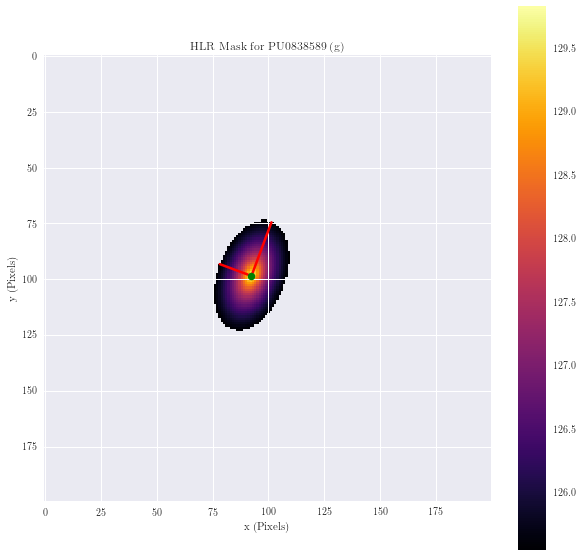


PU0838589 (z) MODEL 
Percentile: 92.773

Interior 
	Flux: 14289.117 ADU 
	Mean: 4.944 ADU 
	RMS:  1.977 ADU 
	Area: 2890 ADU
Exterior 
	Flux: 14281.949 ADU 
	Mean: 0.385 ADU 
	RMS:  0.589 ADU 
	Area: 37110 ADU

SEMI-MAJOR AXIS:   93.885 pixels 
ANGULAR SIZE:      25.349 arcsec 
Half-Light Radius: nan kpc


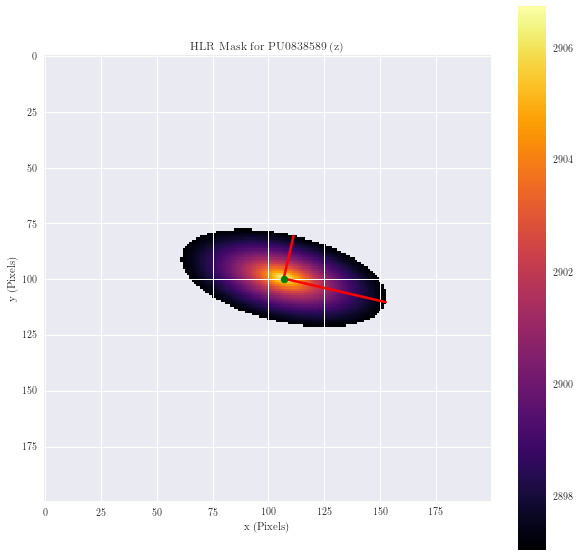


PU0914401 (g) MODEL 
Percentile: 93.682

Interior 
	Flux: 8107.685 ADU 
	Mean: 3.207 ADU 
	RMS:  1.320 ADU 
	Area: 2528 ADU
Exterior 
	Flux: 8101.929 ADU 
	Mean: 0.216 ADU 
	RMS:  0.351 ADU 
	Area: 37472 ADU

SEMI-MAJOR AXIS:   76.357 pixels 
ANGULAR SIZE:      20.616 arcsec 
Half-Light Radius: 9.164 kpc


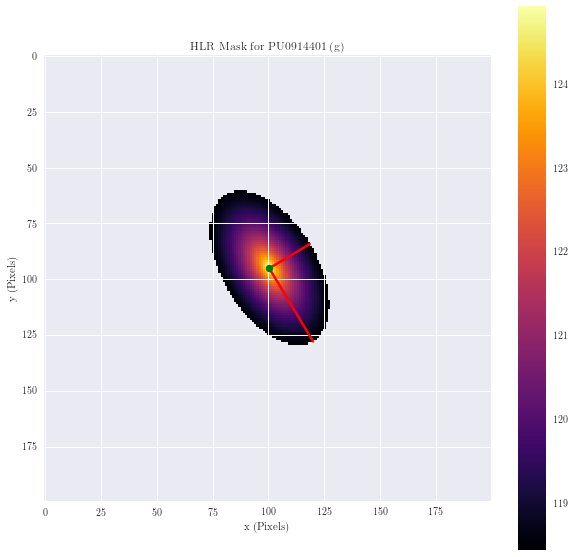


PU0914401 (z) MODEL 
Percentile: 95.371

Interior 
	Flux: 16940.434 ADU 
	Mean: 9.147 ADU 
	RMS:  3.891 ADU 
	Area: 1852 ADU
Exterior 
	Flux: 16936.846 ADU 
	Mean: 0.444 ADU 
	RMS:  0.858 ADU 
	Area: 38148 ADU

SEMI-MAJOR AXIS:   55.622 pixels 
ANGULAR SIZE:      15.018 arcsec 
Half-Light Radius: 6.675 kpc


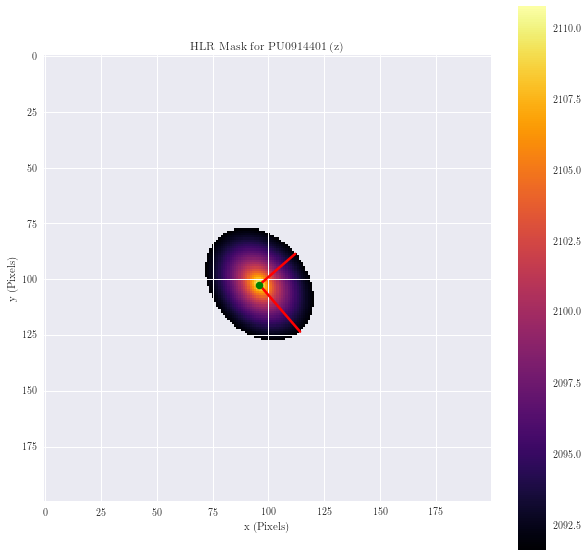


PU1006233 (z) MODEL 
Percentile: 96.572

Interior 
	Flux: 11200.112 ADU 
	Mean: 8.163 ADU 
	RMS:  3.552 ADU 
	Area: 1372 ADU
Exterior 
	Flux: 11193.611 ADU 
	Mean: 0.290 ADU 
	RMS:  0.661 ADU 
	Area: 38628 ADU

SEMI-MAJOR AXIS:   52.818 pixels 
ANGULAR SIZE:      14.261 arcsec 
Half-Light Radius: 1.182 kpc


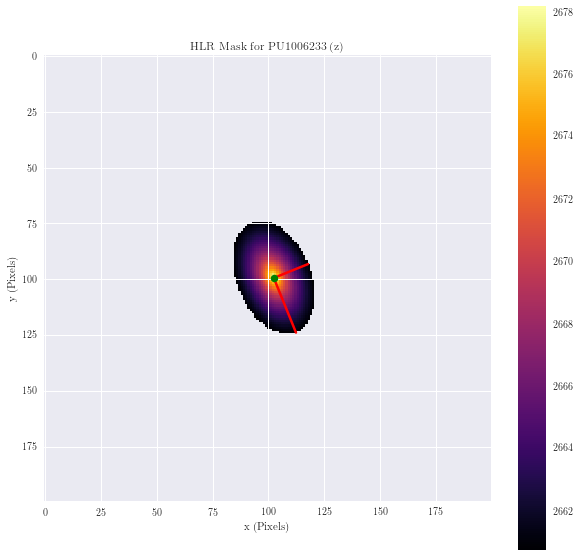


PU1006233 (z1) MODEL 
Percentile: 95.654

Interior 
	Flux: 10903.879 ADU 
	Mean: 6.270 ADU 
	RMS:  2.688 ADU 
	Area: 1739 ADU
Exterior 
	Flux: 10895.212 ADU 
	Mean: 0.285 ADU 
	RMS:  0.569 ADU 
	Area: 38261 ADU

SEMI-MAJOR AXIS:   56.904 pixels 
ANGULAR SIZE:      15.364 arcsec 
Half-Light Radius: 1.274 kpc


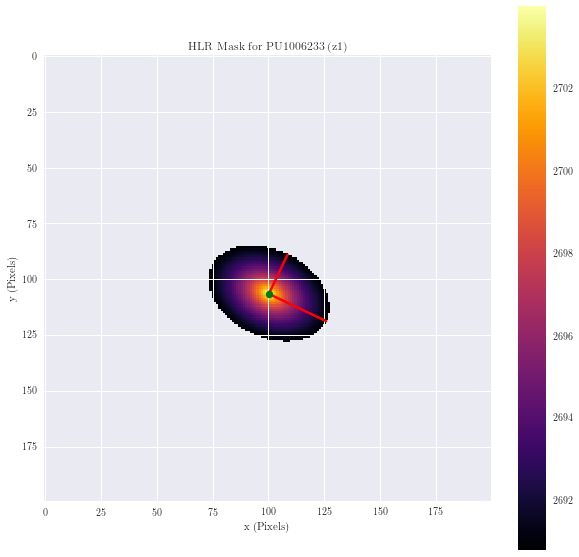


PU1217377 (g) MODEL 
Percentile: 90.605

Interior 
	Flux: 16889.672 ADU 
	Mean: 4.494 ADU 
	RMS:  1.631 ADU 
	Area: 3758 ADU
Exterior 
	Flux: 16899.625 ADU 
	Mean: 0.466 ADU 
	RMS:  0.630 ADU 
	Area: 36242 ADU

SEMI-MAJOR AXIS:   79.852 pixels 
ANGULAR SIZE:      21.560 arcsec 
Half-Light Radius: 0.784 kpc


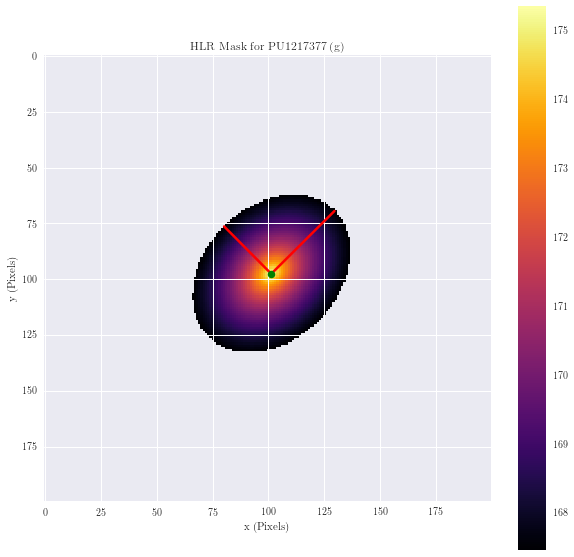


PU1217377 (r) MODEL 
Percentile: 91.660

Interior 
	Flux: 16217.934 ADU 
	Mean: 4.861 ADU 
	RMS:  1.850 ADU 
	Area: 3336 ADU
Exterior 
	Flux: 16204.345 ADU 
	Mean: 0.442 ADU 
	RMS:  0.629 ADU 
	Area: 36664 ADU

SEMI-MAJOR AXIS:   75.237 pixels 
ANGULAR SIZE:      20.314 arcsec 
Half-Light Radius: 0.739 kpc


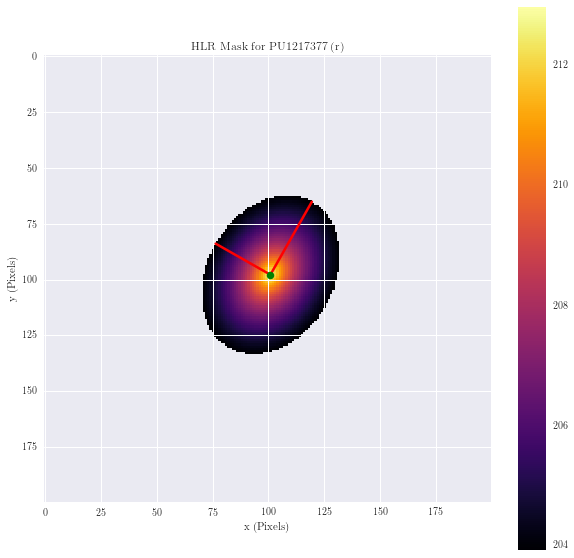


PU1217377 (z) MODEL 
Percentile: 91.387

Interior 
	Flux: 25633.629 ADU 
	Mean: 7.439 ADU 
	RMS:  2.804 ADU 
	Area: 3446 ADU
Exterior 
	Flux: 25622.656 ADU 
	Mean: 0.701 ADU 
	RMS:  0.982 ADU 
	Area: 36554 ADU

SEMI-MAJOR AXIS:   79.257 pixels 
ANGULAR SIZE:      21.399 arcsec 
Half-Light Radius: 0.778 kpc


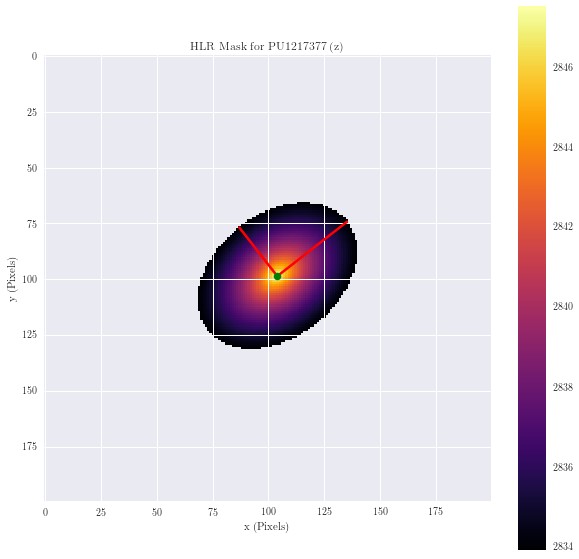


PU1221086 (z) MODEL 
Percentile: 86.528

Interior 
	Flux: 48040.344 ADU 
	Mean: 8.915 ADU 
	RMS:  2.716 ADU 
	Area: 5389 ADU
Exterior 
	Flux: 48039.258 ADU 
	Mean: 1.388 ADU 
	RMS:  1.626 ADU 
	Area: 34611 ADU

SEMI-MAJOR AXIS:   113.136 pixels 
ANGULAR SIZE:      30.547 arcsec 
Half-Light Radius: 2.711 kpc


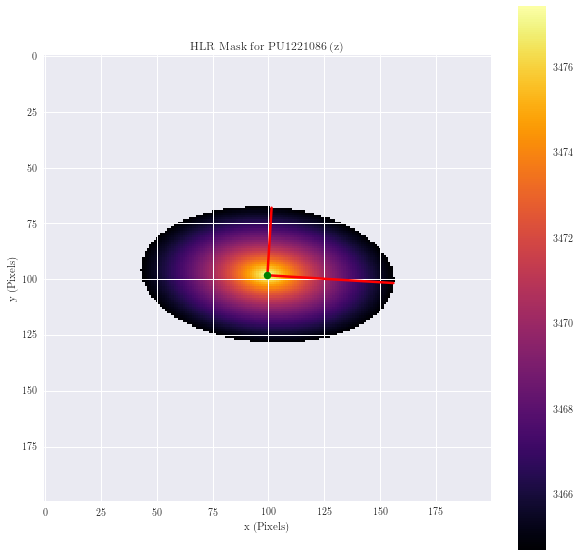


PU1224081 (g) MODEL 
Percentile: 91.094

Interior 
	Flux: 21136.770 ADU 
	Mean: 5.932 ADU 
	RMS:  2.215 ADU 
	Area: 3563 ADU
Exterior 
	Flux: 21142.947 ADU 
	Mean: 0.580 ADU 
	RMS:  0.799 ADU 
	Area: 36437 ADU

SEMI-MAJOR AXIS:   80.425 pixels 
ANGULAR SIZE:      21.715 arcsec 
Half-Light Radius: 0.056 kpc


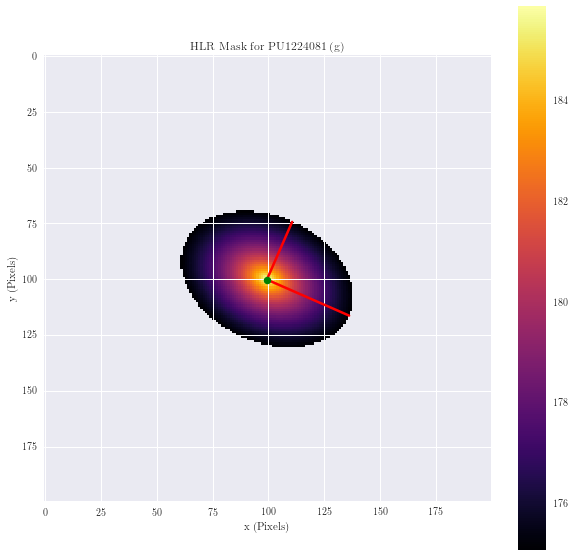


PU1224081 (r) MODEL 
Percentile: 91.367

Interior 
	Flux: 22960.299 ADU 
	Mean: 6.649 ADU 
	RMS:  2.509 ADU 
	Area: 3453 ADU
Exterior 
	Flux: 22965.207 ADU 
	Mean: 0.628 ADU 
	RMS:  0.878 ADU 
	Area: 36547 ADU

SEMI-MAJOR AXIS:   78.126 pixels 
ANGULAR SIZE:      21.094 arcsec 
Half-Light Radius: 0.054 kpc


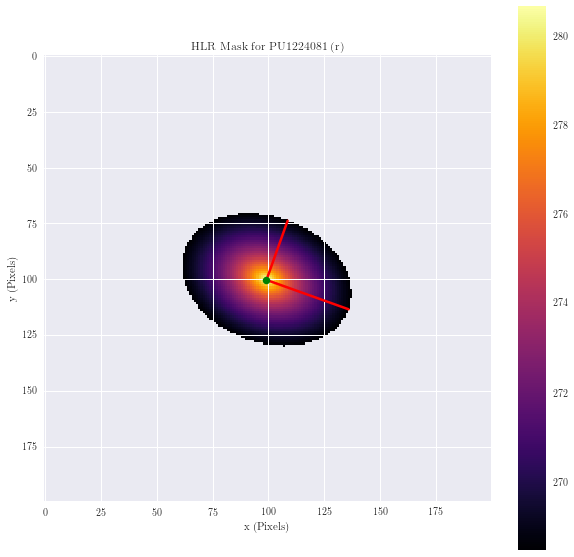


PU1224081 (z) MODEL 
Percentile: 91.953

Interior 
	Flux: 33795.449 ADU 
	Mean: 10.499 ADU 
	RMS:  4.045 ADU 
	Area: 3219 ADU
Exterior 
	Flux: 33796.855 ADU 
	Mean: 0.919 ADU 
	RMS:  1.328 ADU 
	Area: 36781 ADU

SEMI-MAJOR AXIS:   73.358 pixels 
ANGULAR SIZE:      19.807 arcsec 
Half-Light Radius: 0.051 kpc


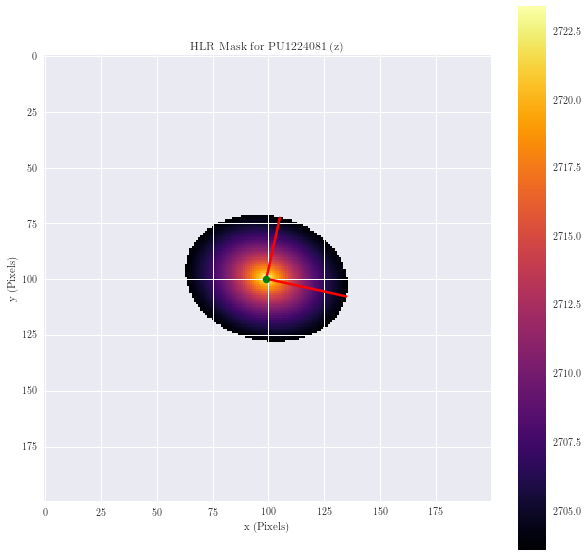


PU1251013 (g) MODEL 
Percentile: 93.848

Interior 
	Flux: 11729.564 ADU 
	Mean: 4.766 ADU 
	RMS:  1.955 ADU 
	Area: 2461 ADU
Exterior 
	Flux: 11731.224 ADU 
	Mean: 0.313 ADU 
	RMS:  0.517 ADU 
	Area: 37539 ADU

SEMI-MAJOR AXIS:   67.168 pixels 
ANGULAR SIZE:      18.135 arcsec 
Half-Light Radius: 7.580 kpc


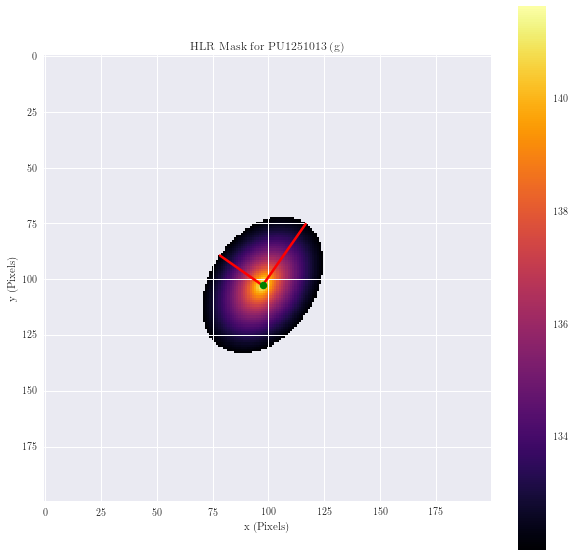


PU1251013 (r) MODEL 
Percentile: 93.164

Interior 
	Flux: 12138.289 ADU 
	Mean: 4.438 ADU 
	RMS:  1.777 ADU 
	Area: 2735 ADU
Exterior 
	Flux: 12131.677 ADU 
	Mean: 0.326 ADU 
	RMS:  0.512 ADU 
	Area: 37265 ADU

SEMI-MAJOR AXIS:   64.372 pixels 
ANGULAR SIZE:      17.380 arcsec 
Half-Light Radius: 7.265 kpc


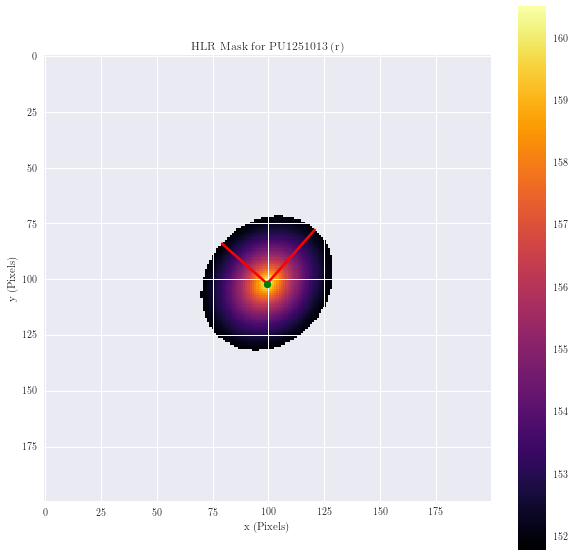


PU1251013 (z) MODEL 
Percentile: 92.949

Interior 
	Flux: 38510.336 ADU 
	Mean: 13.651 ADU 
	RMS:  5.428 ADU 
	Area: 2821 ADU
Exterior 
	Flux: 38509.176 ADU 
	Mean: 1.036 ADU 
	RMS:  1.602 ADU 
	Area: 37179 ADU

SEMI-MAJOR AXIS:   67.653 pixels 
ANGULAR SIZE:      18.266 arcsec 
Half-Light Radius: 7.635 kpc


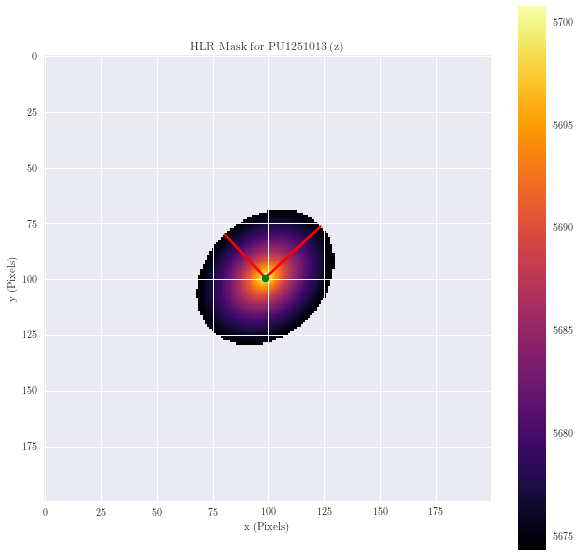


DF30 (g) MODEL 
Percentile: 95.977

Interior 
	Flux: 9061.442 ADU 
	Mean: 5.628 ADU 
	RMS:  2.422 ADU 
	Area: 1610 ADU
Exterior 
	Flux: 9059.913 ADU 
	Mean: 0.236 ADU 
	RMS:  0.493 ADU 
	Area: 38390 ADU

SEMI-MAJOR AXIS:   51.970 pixels 
ANGULAR SIZE:      14.032 arcsec 
Half-Light Radius: 6.941 kpc


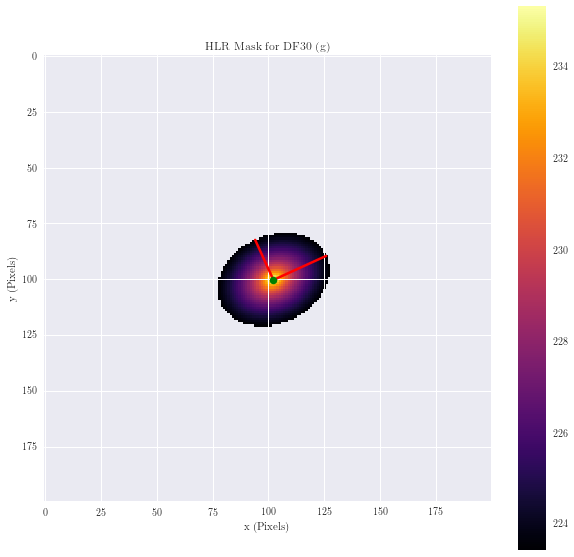


DF30 (z) MODEL 
Percentile: 97.007

Interior 
	Flux: 19471.699 ADU 
	Mean: 16.254 ADU 
	RMS:  7.094 ADU 
	Area: 1198 ADU
Exterior 
	Flux: 19468.566 ADU 
	Mean: 0.502 ADU 
	RMS:  1.237 ADU 
	Area: 38802 ADU

SEMI-MAJOR AXIS:   43.715 pixels 
ANGULAR SIZE:      11.803 arcsec 
Half-Light Radius: 5.838 kpc


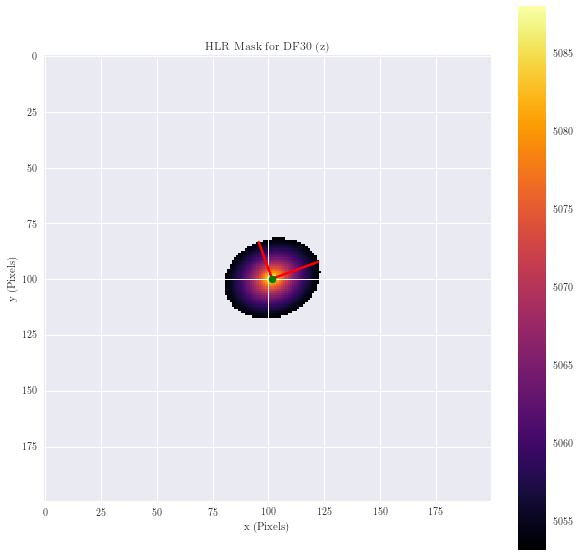


DF07 (g) MODEL 
Percentile: 93.965

Interior 
	Flux: 12995.098 ADU 
	Mean: 5.381 ADU 
	RMS:  2.210 ADU 
	Area: 2415 ADU
Exterior 
	Flux: 13004.577 ADU 
	Mean: 0.346 ADU 
	RMS:  0.579 ADU 
	Area: 37585 ADU

SEMI-MAJOR AXIS:   64.026 pixels 
ANGULAR SIZE:      17.287 arcsec 
Half-Light Radius: 7.717 kpc


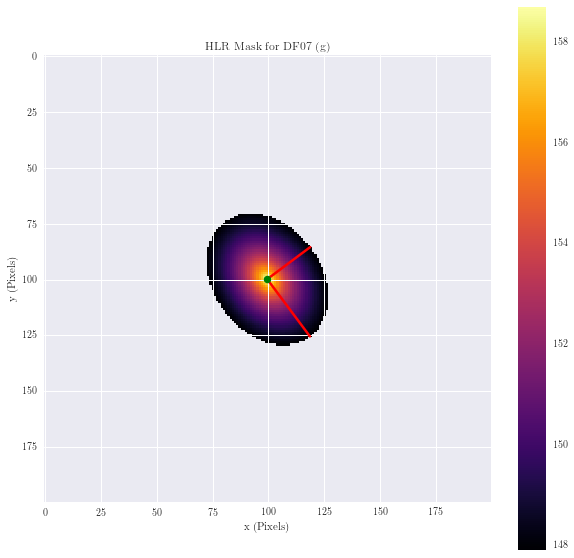


DF07 (r) MODEL 
Percentile: 94.600

Interior 
	Flux: 12681.658 ADU 
	Mean: 5.868 ADU 
	RMS:  2.450 ADU 
	Area: 2161 ADU
Exterior 
	Flux: 12689.447 ADU 
	Mean: 0.335 ADU 
	RMS:  0.596 ADU 
	Area: 37839 ADU

SEMI-MAJOR AXIS:   59.659 pixels 
ANGULAR SIZE:      16.108 arcsec 
Half-Light Radius: 7.191 kpc


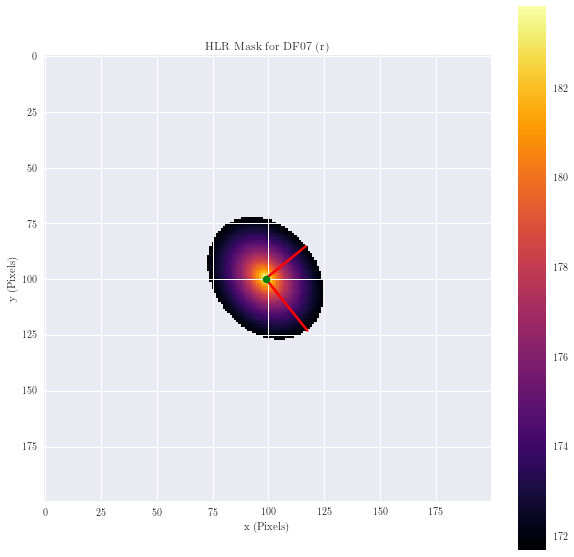


DF07 (z) MODEL 
Percentile: 93.594

Interior 
	Flux: 33563.164 ADU 
	Mean: 13.095 ADU 
	RMS:  5.321 ADU 
	Area: 2563 ADU
Exterior 
	Flux: 33552.152 ADU 
	Mean: 0.896 ADU 
	RMS:  1.455 ADU 
	Area: 37437 ADU

SEMI-MAJOR AXIS:   65.815 pixels 
ANGULAR SIZE:      17.770 arcsec 
Half-Light Radius: 7.933 kpc


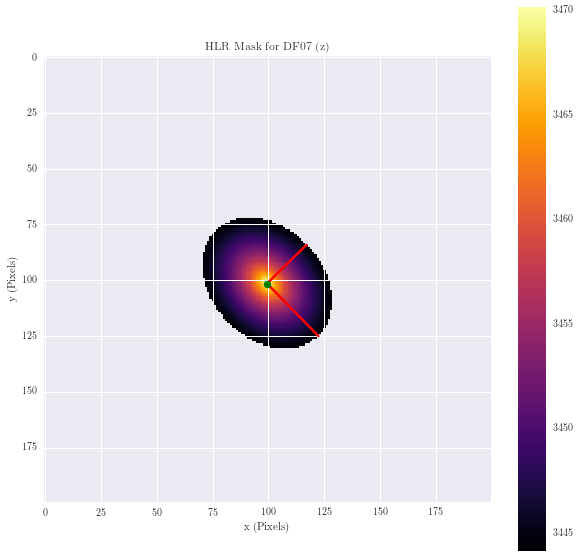


DF40 (g) MODEL 
Percentile: 97.173

Interior 
	Flux: 5586.113 ADU 
	Mean: 4.939 ADU 
	RMS:  2.160 ADU 
	Area: 1131 ADU
Exterior 
	Flux: 5589.672 ADU 
	Mean: 0.144 ADU 
	RMS:  0.365 ADU 
	Area: 38869 ADU

SEMI-MAJOR AXIS:   55.974 pixels 
ANGULAR SIZE:      15.113 arcsec 
Half-Light Radius: 7.949 kpc


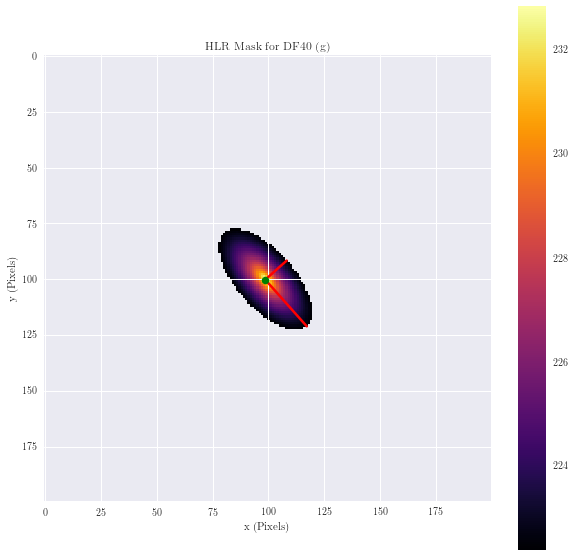


DF40 (r) MODEL 
Percentile: 97.739

Interior 
	Flux: 7082.156 ADU 
	Mean: 7.826 ADU 
	RMS:  3.438 ADU 
	Area: 905 ADU
Exterior 
	Flux: 7075.384 ADU 
	Mean: 0.181 ADU 
	RMS:  0.522 ADU 
	Area: 39095 ADU

SEMI-MAJOR AXIS:   44.479 pixels 
ANGULAR SIZE:      12.009 arcsec 
Half-Light Radius: 6.317 kpc


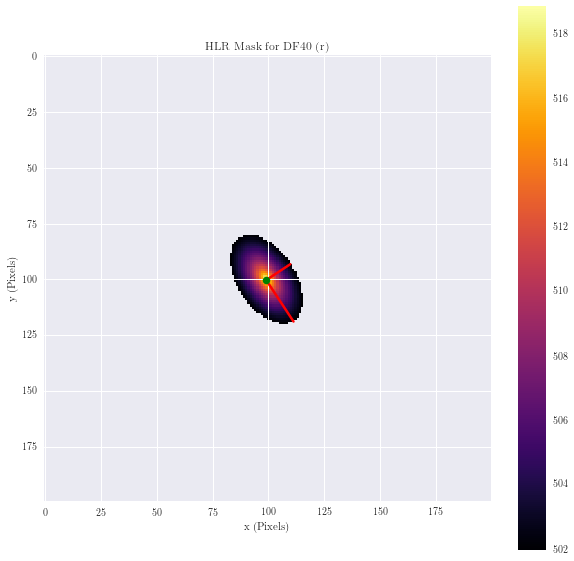


DF40 (z) MODEL 
Percentile: 95.928

Interior 
	Flux: 11980.011 ADU 
	Mean: 7.354 ADU 
	RMS:  3.160 ADU 
	Area: 1629 ADU
Exterior 
	Flux: 11989.466 ADU 
	Mean: 0.312 ADU 
	RMS:  0.648 ADU 
	Area: 38371 ADU

SEMI-MAJOR AXIS:   50.741 pixels 
ANGULAR SIZE:      13.700 arcsec 
Half-Light Radius: 7.206 kpc


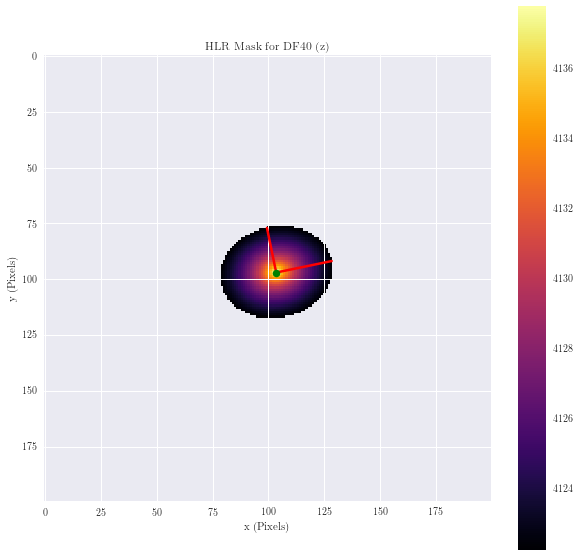


DF08 (g) MODEL 
Percentile: 96.245

Interior 
	Flux: 3806.147 ADU 
	Mean: 2.534 ADU 
	RMS:  1.095 ADU 
	Area: 1502 ADU
Exterior 
	Flux: 3804.677 ADU 
	Mean: 0.099 ADU 
	RMS:  0.215 ADU 
	Area: 38498 ADU

SEMI-MAJOR AXIS:   46.002 pixels 
ANGULAR SIZE:      12.420 arcsec 
Half-Light Radius: 5.926 kpc


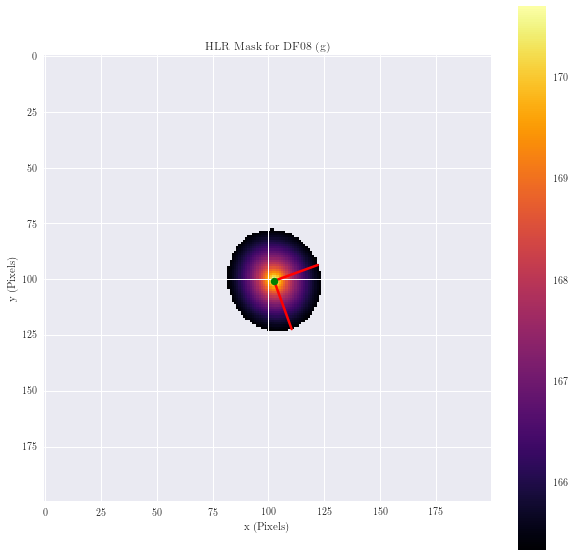


DF08 (r) MODEL 
Percentile: 96.353

Interior 
	Flux: 7141.961 ADU 
	Mean: 4.895 ADU 
	RMS:  2.118 ADU 
	Area: 1459 ADU
Exterior 
	Flux: 7144.584 ADU 
	Mean: 0.185 ADU 
	RMS:  0.409 ADU 
	Area: 38541 ADU

SEMI-MAJOR AXIS:   47.399 pixels 
ANGULAR SIZE:      12.798 arcsec 
Half-Light Radius: 6.106 kpc


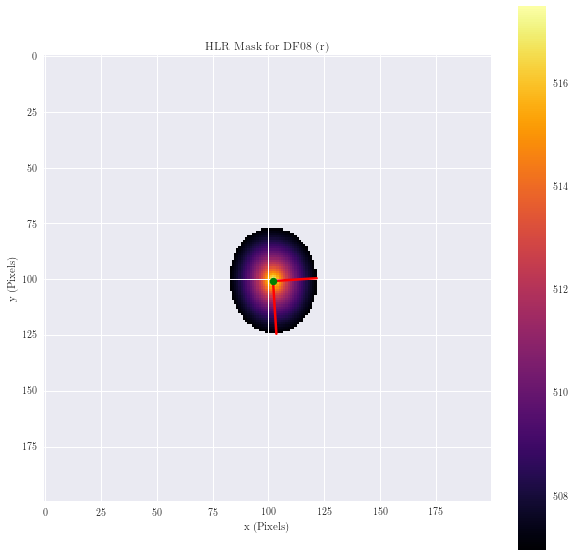


DF08 (z) MODEL 
Percentile: 96.870

Interior 
	Flux: 7908.747 ADU 
	Mean: 6.317 ADU 
	RMS:  2.751 ADU 
	Area: 1252 ADU
Exterior 
	Flux: 7909.318 ADU 
	Mean: 0.204 ADU 
	RMS:  0.491 ADU 
	Area: 38748 ADU

SEMI-MAJOR AXIS:   45.427 pixels 
ANGULAR SIZE:      12.265 arcsec 
Half-Light Radius: 5.852 kpc


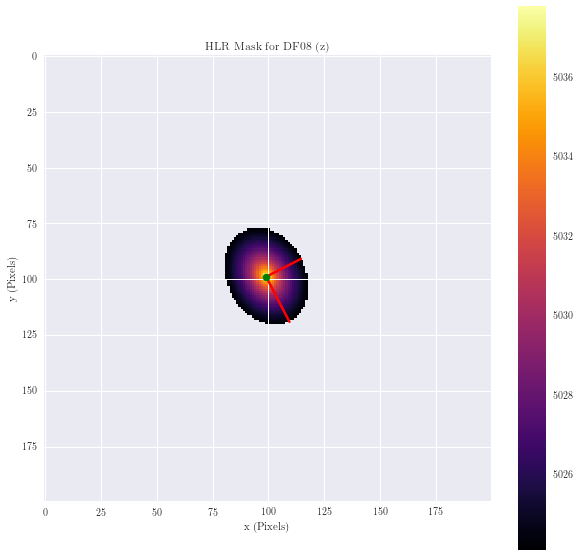


DF17 (g) MODEL 
Percentile: 92.617

Interior 
	Flux: 8208.202 ADU 
	Mean: 2.779 ADU 
	RMS:  1.097 ADU 
	Area: 2954 ADU
Exterior 
	Flux: 8212.782 ADU 
	Mean: 0.222 ADU 
	RMS:  0.334 ADU 
	Area: 37046 ADU

SEMI-MAJOR AXIS:   74.060 pixels 
ANGULAR SIZE:      19.996 arcsec 
Half-Light Radius: nan kpc


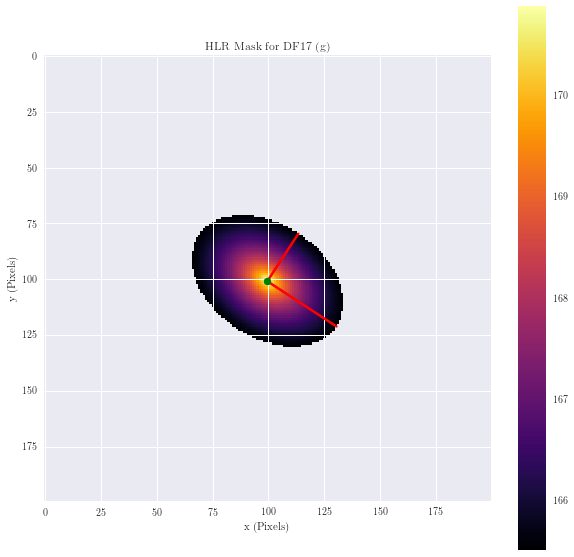


DF17 (r) MODEL 
Percentile: 93.691

Interior 
	Flux: 13723.617 ADU 
	Mean: 5.437 ADU 
	RMS:  2.211 ADU 
	Area: 2524 ADU
Exterior 
	Flux: 13722.413 ADU 
	Mean: 0.366 ADU 
	RMS:  0.600 ADU 
	Area: 37476 ADU

SEMI-MAJOR AXIS:   56.710 pixels 
ANGULAR SIZE:      15.312 arcsec 
Half-Light Radius: nan kpc


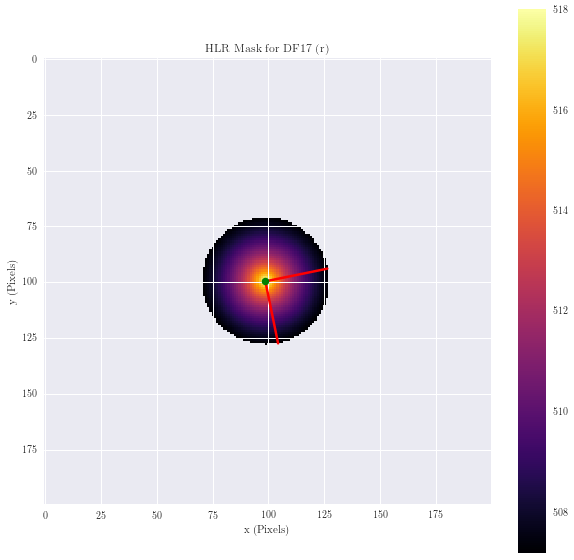


DF17 (z) MODEL 
Percentile: 96.636

Interior 
	Flux: 13150.820 ADU 
	Mean: 9.770 ADU 
	RMS:  4.243 ADU 
	Area: 1346 ADU
Exterior 
	Flux: 13157.931 ADU 
	Mean: 0.340 ADU 
	RMS:  0.786 ADU 
	Area: 38654 ADU

SEMI-MAJOR AXIS:   41.469 pixels 
ANGULAR SIZE:      11.197 arcsec 
Half-Light Radius: nan kpc


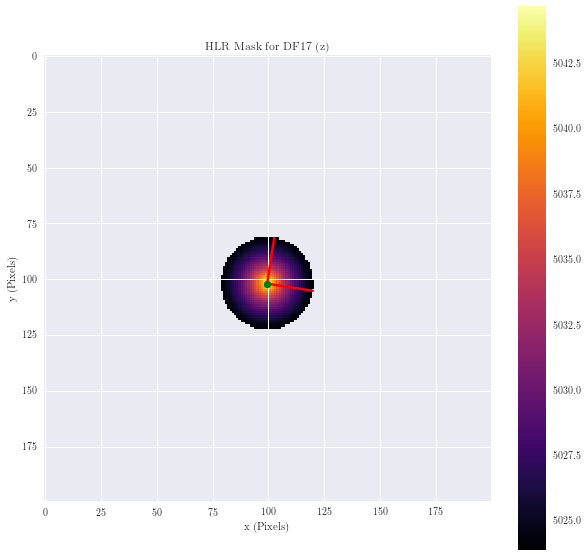


DF03 (g) MODEL 
Percentile: 96.733

Interior 
	Flux: 4161.863 ADU 
	Mean: 3.184 ADU 
	RMS:  1.387 ADU 
	Area: 1307 ADU
Exterior 
	Flux: 4163.210 ADU 
	Mean: 0.108 ADU 
	RMS:  0.252 ADU 
	Area: 38693 ADU

SEMI-MAJOR AXIS:   58.625 pixels 
ANGULAR SIZE:      15.829 arcsec 
Half-Light Radius: 10.763 kpc


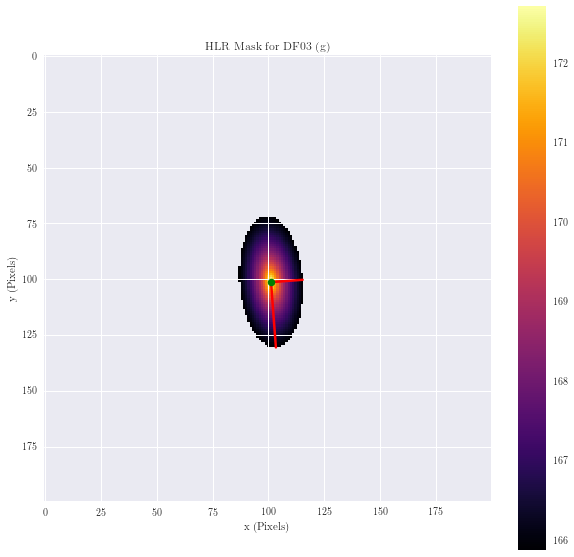


DF03 (r) MODEL 
Percentile: 97.256

Interior 
	Flux: 5795.635 ADU 
	Mean: 5.278 ADU 
	RMS:  2.310 ADU 
	Area: 1098 ADU
Exterior 
	Flux: 5800.003 ADU 
	Mean: 0.149 ADU 
	RMS:  0.385 ADU 
	Area: 38902 ADU

SEMI-MAJOR AXIS:   48.296 pixels 
ANGULAR SIZE:      13.040 arcsec 
Half-Light Radius: 8.867 kpc


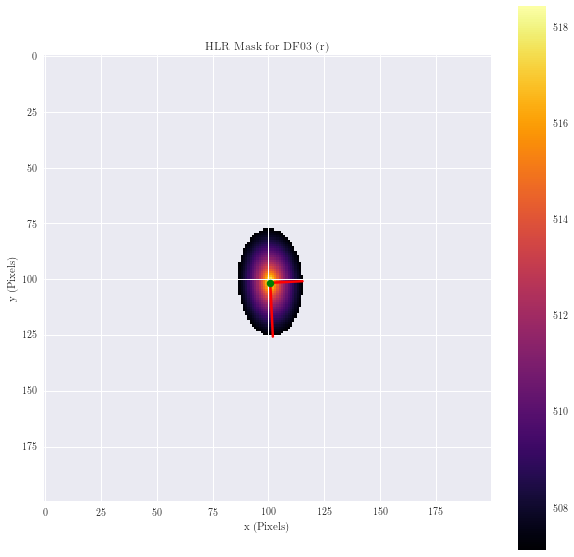


DF03 (z) MODEL 
Percentile: 97.866

Interior 
	Flux: 7780.250 ADU 
	Mean: 9.110 ADU 
	RMS:  3.992 ADU 
	Area: 854 ADU
Exterior 
	Flux: 7785.414 ADU 
	Mean: 0.199 ADU 
	RMS:  0.594 ADU 
	Area: 39146 ADU

SEMI-MAJOR AXIS:   53.012 pixels 
ANGULAR SIZE:      14.313 arcsec 
Half-Light Radius: 9.733 kpc


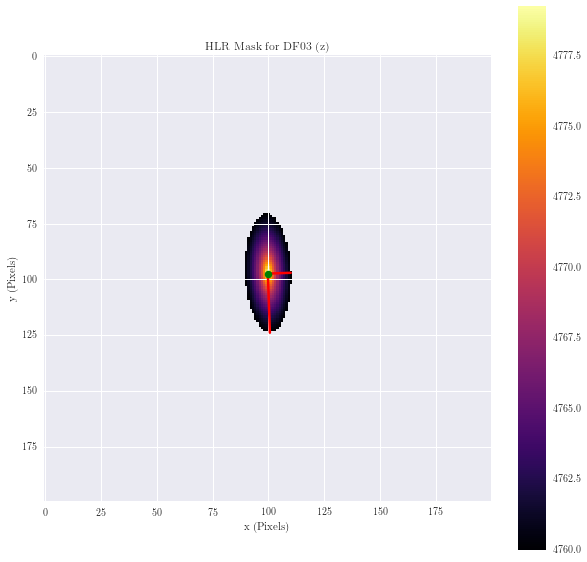


PU1304535 (g) MODEL 
Percentile: 88.682

Interior 
	Flux: 21503.711 ADU 
	Mean: 4.749 ADU 
	RMS:  1.555 ADU 
	Area: 4528 ADU
Exterior 
	Flux: 21511.594 ADU 
	Mean: 0.606 ADU 
	RMS:  0.764 ADU 
	Area: 35472 ADU

SEMI-MAJOR AXIS:   80.389 pixels 
ANGULAR SIZE:      21.705 arcsec 
Half-Light Radius: 10.761 kpc


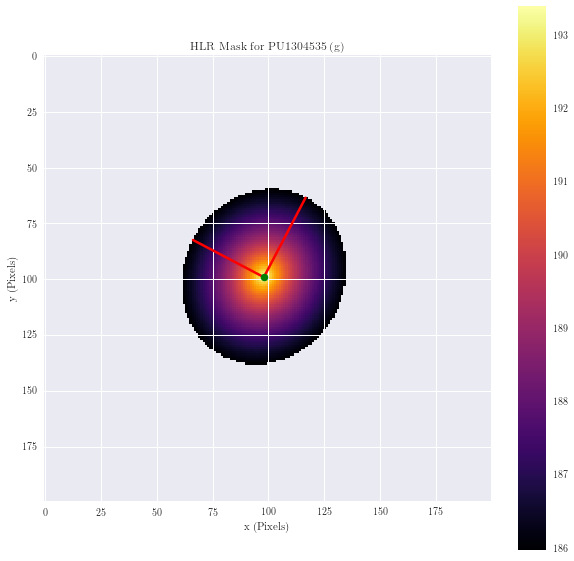


PU1304535 (r) MODEL 
Percentile: 88.748

Interior 
	Flux: 32897.168 ADU 
	Mean: 7.309 ADU 
	RMS:  2.404 ADU 
	Area: 4501 ADU
Exterior 
	Flux: 32913.703 ADU 
	Mean: 0.927 ADU 
	RMS:  1.170 ADU 
	Area: 35499 ADU

SEMI-MAJOR AXIS:   79.515 pixels 
ANGULAR SIZE:      21.469 arcsec 
Half-Light Radius: 10.643 kpc


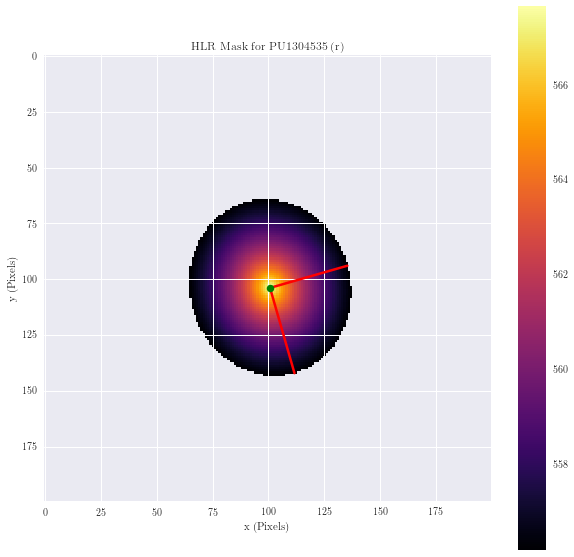


PU1304535 (z) MODEL 
Percentile: 94.238

Interior 
	Flux: 64224.961 ADU 
	Mean: 27.863 ADU 
	RMS:  11.516 ADU 
	Area: 2305 ADU
Exterior 
	Flux: 64284.793 ADU 
	Mean: 1.705 ADU 
	RMS:  2.928 ADU 
	Area: 37695 ADU

SEMI-MAJOR AXIS:   57.761 pixels 
ANGULAR SIZE:      15.595 arcsec 
Half-Light Radius: 7.732 kpc


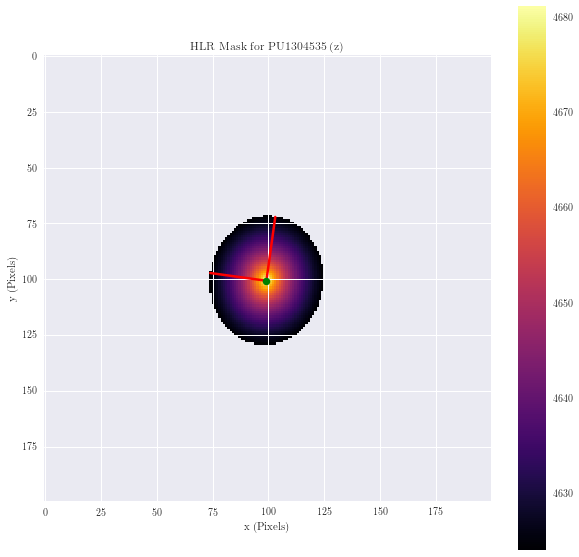

In [56]:
for obs in obs_list:

    background_statistics(obs, plot=False)
    half_light_mask(obs, percent=90, plot=True, verbose=True)

The plots above depict the half-light radius mask for all previously observed UDGs. We will analyze pixel variations in the regions defined by these masks.

# Characterizing Pixel Intensity Variations
See $\S6$: "Searching for Structure in Point Data" from <u> Statistics, Data Mining, and Machine Learning in Astronomy </u> by Ivezic, Connolly, VanderPlas, and Gray.

## Kernel Density Estimation
Given a sample, Kernel Density Estimation (KDE) is a non-parametric, smoothing technique used to construct an estimate for the underlying probability distribution used to generate the sample data. KDE is mathematically defined as

<center> $\hat{f}_N(x) = \frac{1}{h^D} \sum_{i=1}^N K\left(\frac{d(x,x_i)}{h}\right)$, </center>

where $K(u)$ is the kernel and $h$ is the bandwidth (i.e. size of kernel). KDE estimates the underlying distribution by taking a weighted mean of the sample data, using the kernel fuction as the weight.


### Using a Gaussian Kernel
We use the Gaussian kernel:

<center> $K(u) = \frac{1}{(2\pi)^{D/2}} \exp \left(-u^2/2 \right)$, </center>

where $D$ is the number of dimensions (i.e. 1 in this case), and $u = d(x, x_i)/h$. 

I chose a Gaussian kernel for the KDE since the underlying distribution of pixel intensities should be roughly Gaussian, due to the Central Limit Theorem. More specifically, the background fluctuation is roughly Gaussian. In low-surface brightness astronomy, the background is the dominant source of the flux.

KDE can easily be modified to use other kernels, including but not limited to 'exponential,' 'tophat,' and 'epanechnikov' kernels. Due to the relatively large number of pixels available, the KDE results using all kernels vary minimally. To plot the results from other kernels, include each kernel keyword into the "kernel_list" in the code below.

The bandwidth choice has a greater impact on KDE as opposed to the kernel choice when large number of pixels are available. Cross-validation can be used to optimize for the bandwidth, which will be implemented in the future. Here, I have determined the best KDE bandwidth by eye for each band. 


### Implementing a Gaussian KDE on Pixel Intensity Variations
Below follows the implementation of Scikit-Learn's 1D Kernel Density Estimation Example, which can be found here:
http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

In [58]:
def plot_kde(data, mask=None, band='g', background=None, file=None, verbose=False):
    
    kernel_list = ['gaussian'] # Add Other Kernels: 'exponential', 'tophat', 'epanechnikov', 'gaussian'
    
    if mask==None:
        mask = np.ones(data.shape, dtype=bool)


    # IMAGE WITH HALF-LIGHT RADIUS MASK    
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    ax1.set_title("{0} ({1}) HLR Mask".format(obs.name, obs.band))
    ax1.set_xlabel(r"x (Pixels)")
    ax1.set_ylabel(r"y (Pixels)")
    
    image = 1. * data
    image[~mask] = np.nan
    img = plt.imshow(image, interpolation='none', aspect='equal', cmap='inferno')
    plt.colorbar(img, ax=ax1)
    
    
    # INTENSITY HISTOGRAM OF MASKED IMAGES
    ax2 = fig.add_subplot(122)
    ax2.set_facecolor('white')
    ax2.set_title(r"{0} ({1}) Pixel Variation".format(obs.name, obs.band))
    ax2.set_xlabel(r"Pixel Intensity (ADU)")
    ax2.set_ylabel(r"PDF")
    
    
    # Plots Gaussian.
    arr = np.sort(data[mask].reshape((np.sum(mask),1)))
    x = np.linspace(np.min(arr), np.max(arr), arr.size)[:, np.newaxis]
        
    if background != None:
        obs.gal_mean   = np.mean(data[mask])
        obs.gal_median = np.median(data[mask])
        obs.gal_stdev  = np.sqrt( np.sum(data[mask][data[mask]<0]**2) / (data[mask][data[mask]<0].size-1) )

        gauss = norm.pdf(x, obs.gal_mean, obs.gal_stdev)
        plt.plot(x, gauss, color='g')
    
    
    # Plots mean, 1-sigma, 2-sigma, and 3-sigma.
    mu, sigma = norm.fit(arr)  
    plt.axvline(x=mu,         linestyle="-",  color='g', alpha=0.5)
    plt.axvline(x=mu+sigma,   linestyle="-.", color='g', alpha=0.5)
    plt.axvline(x=mu-sigma,   linestyle="-.", color='g', alpha=0.5)
    plt.axvline(x=mu-2*sigma, linestyle="--", color='g', alpha=0.5)
    plt.axvline(x=mu+2*sigma, linestyle="--", color='g', alpha=0.5)
    plt.axvline(x=mu-3*sigma, linestyle=":",  color='g', alpha=0.5)
    plt.axvline(x=mu+3*sigma, linestyle=":",  color='g', alpha=0.5)
    if verbose:
        print("\n\tmu:     %.3f" % mu,
              "\n\tsigma:  %.3f" % sigma,
              "\n\tMedian: %.3f" % np.median(arr))

    
    # Plots Histogram of Masked Data.
    ax2.hist(data[mask], bins=30, normed=True, alpha=0.3)
    
    
    # Plots the KDE Distribution.
    for kernel in kernel_list:
        if any([band == 'z',band=='z1']):
            kde = KernelDensity(kernel=kernel, bandwidth=1.75).fit(arr)
        if band == 'r':
            kde = KernelDensity(kernel=kernel, bandwidth=0.85).fit(arr)
        if band == 'g':
            kde = KernelDensity(kernel=kernel, bandwidth=0.7).fit(arr)

        y = np.exp(kde.score_samples(x))
        ax2.plot(x[:, 0], y, '-', c='r', label="kernel = '{0}'".format(kernel))

    
    ax2.legend(loc='best')
    if file != None:
        plt.savefig(file, format='png', bbox_inches='tight')
    plt.show()
    plt.close()
    
    return x,y

For each unique band for every target, I have plotted the mask-applied residual image (left) and its pixel-intensity histogram (right). The Gaussian kernel density estimate is plotted in red. The green curve is a Gaussian centered on the mean intensity of the mask-applied residual. The 1st, 2nd, and 3rd standard deviations of the Gaussian are denoted by dashed green lines. The choice of bandwidth varies with each band. The appropriate bandwidth choice is necessary to prevent over- and underfitting the distribution.

# Results

If the candidates were perfectly smooth objects (i.e. lacking features, structures, and clumpiness), subtracting a smooth model from the original image should remove the galaxy in its entirety. However, if structures remain, we will see it in the residual images. In the case where the model image is a composite of a uniform background (with no errors) and a near-exponential profile for the galaxy, the residual image of a featureless galaxy should have a mean of zero with Poisson noise from both the background and the galaxy. To first order, a featureless galaxy will have a pixel intensity variation modeled by $\mathcal{N}(\mu=0, \sigma)$, where $\sigma$ is standard deviation of the mask-applied residual image.

### Mean Square Error
The mean square error (MSE) measures the average squared deviation from the actual and predicted values, such that
<center> $\mathrm{MSE} = \frac{1}{n} \sum\limits_{i=1}^N \left(Y_i - \widehat{Y}_i \right)^2$ </center>.

The assume that the true distribution is the one estimated by Gaussian KDE. The predicted distribution is determined by theory. I use the MSE to quantify the amount of pixel variation observed in each of our targets.

In [34]:
def set_mse(obs, sigma=5, verbose=False): 
    
    x,y = obs.kde
    gauss1 = norm.pdf(x, 0, obs.gal_stdev)
        
    obs.mse = np.sum(((y-gauss1)**2)) / y.size

    return obs.mse

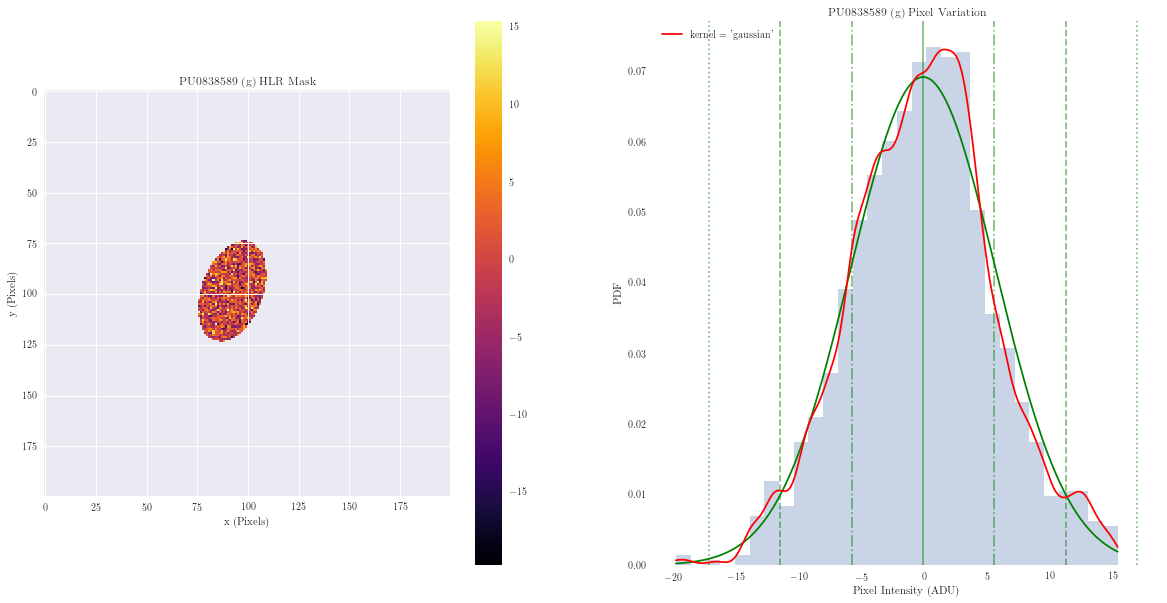

PU0838589 (g) 
	Background Mean:   124.481 ADU 
	Background StDev:  0.001 ADU 
	Galaxy Mean:       -0.116 ADU 
	Galaxy Median:     0.003 ADU 
	Galaxy StDev:      5.768 ADU 
	Recessional Vel:   nan ADU 
	Mean Square Error: 1.484 ADU


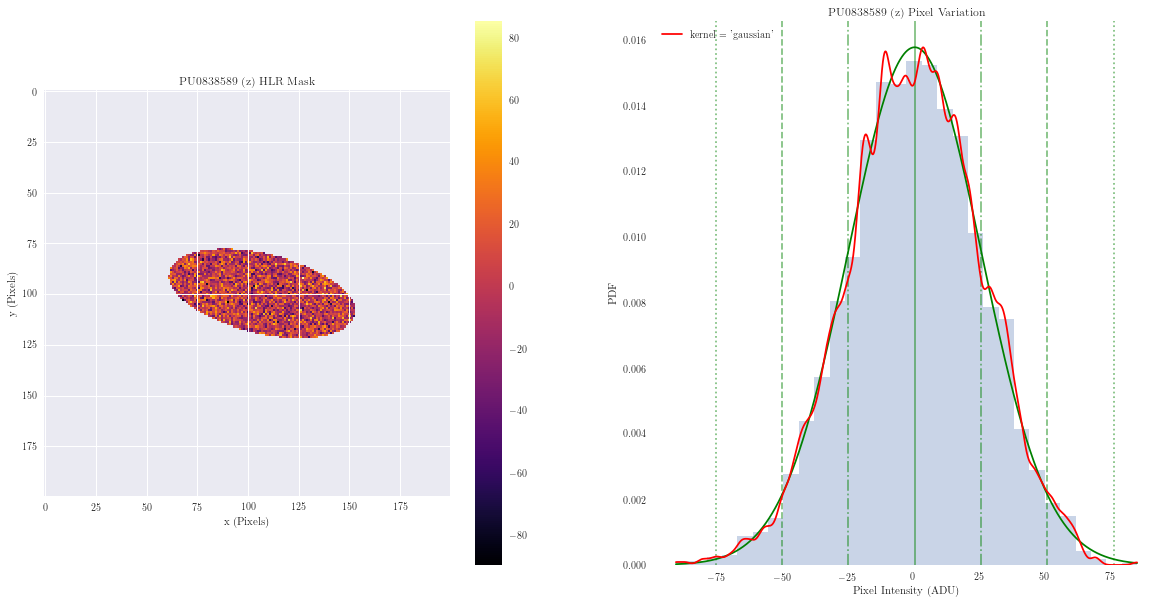

PU0838589 (z) 
	Background Mean:   2894.259 ADU 
	Background StDev:  0.023 ADU 
	Galaxy Mean:       0.677 ADU 
	Galaxy Median:     0.942 ADU 
	Galaxy StDev:      25.242 ADU 
	Recessional Vel:   nan ADU 
	Mean Square Error: 0.180 ADU


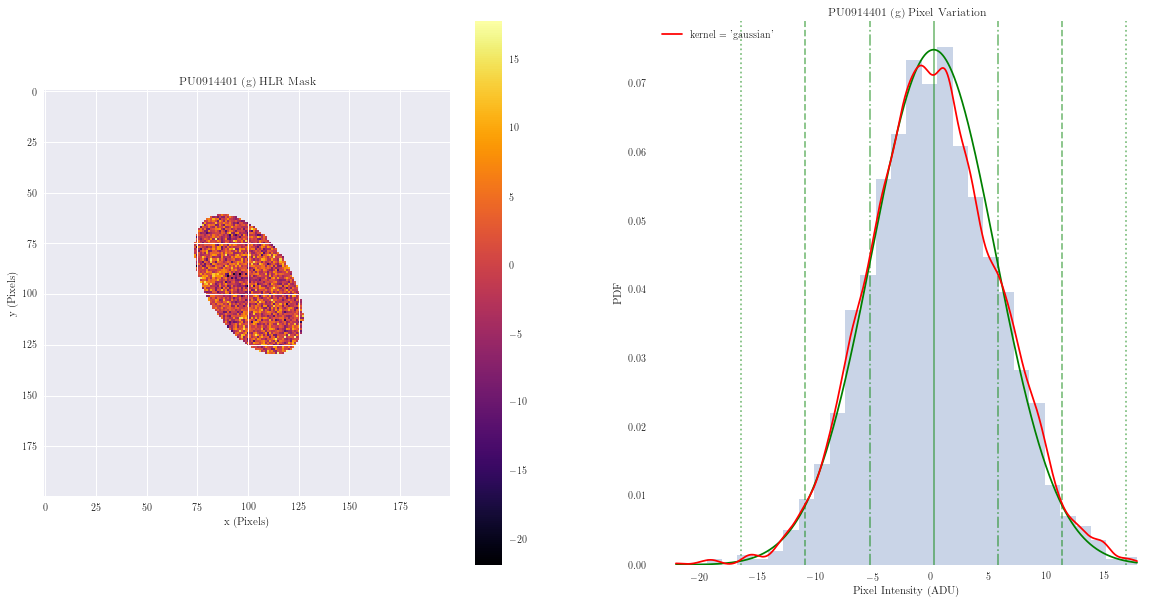

PU0914401 (g) 
	Background Mean:   116.684 ADU 
	Background StDev:  0.018 ADU 
	Galaxy Mean:       0.263 ADU 
	Galaxy Median:     0.145 ADU 
	Galaxy StDev:      5.335 ADU 
	Recessional Vel:   6558.000 ADU 
	Mean Square Error: 3.394 ADU


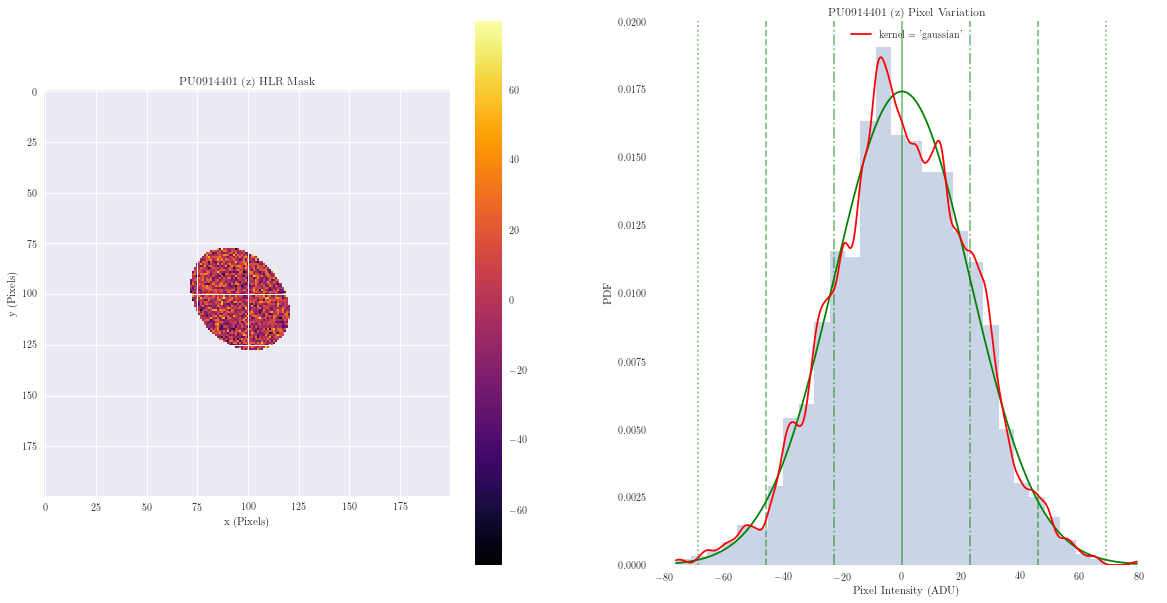

PU0914401 (z) 
	Background Mean:   2086.691 ADU 
	Background StDev:  0.020 ADU 
	Galaxy Mean:       0.272 ADU 
	Galaxy Median:     -0.114 ADU 
	Galaxy StDev:      22.867 ADU 
	Recessional Vel:   6558.000 ADU 
	Mean Square Error: 0.140 ADU


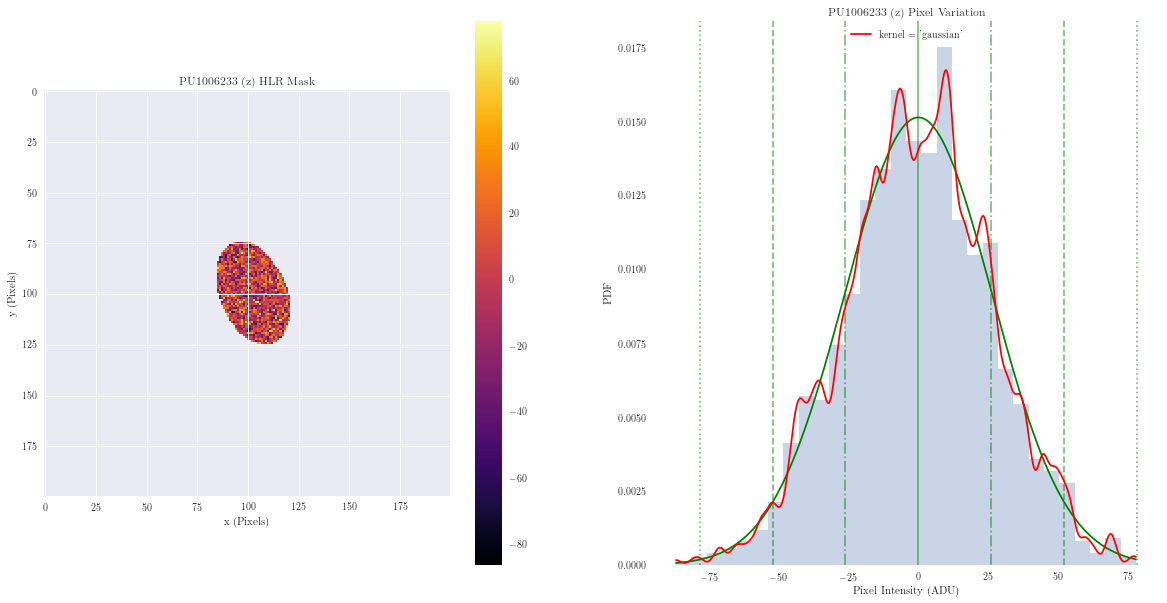

PU1006233 (z) 
	Background Mean:   2656.429 ADU 
	Background StDev:  0.006 ADU 
	Galaxy Mean:       0.078 ADU 
	Galaxy Median:     0.485 ADU 
	Galaxy StDev:      26.304 ADU 
	Recessional Vel:   1202.000 ADU 
	Mean Square Error: 0.079 ADU


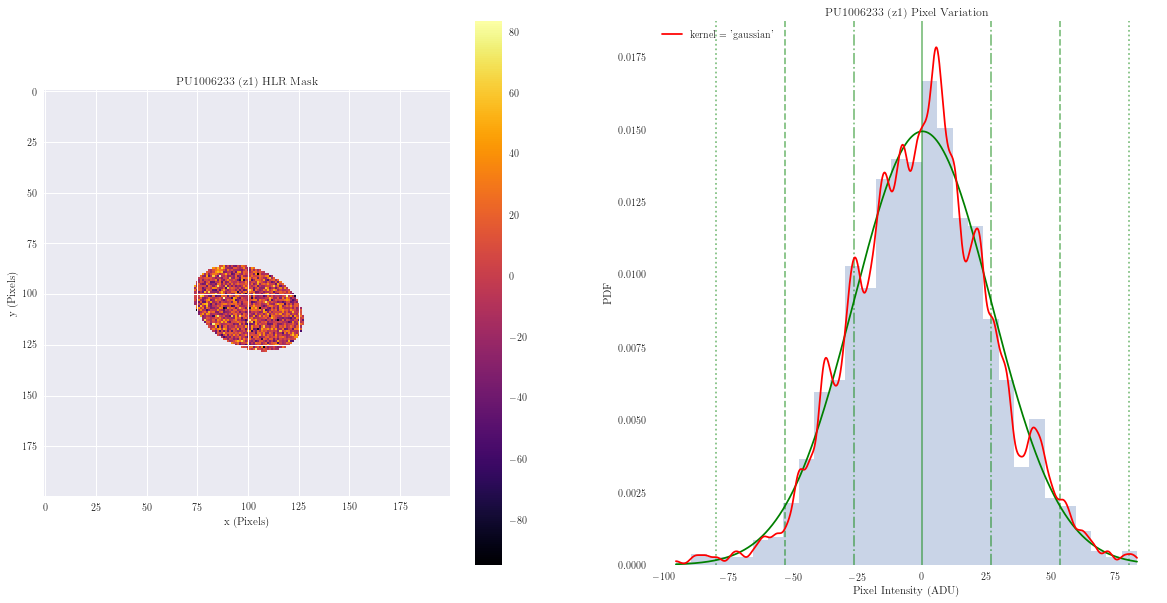

PU1006233 (z1) 
	Background Mean:   2687.441 ADU 
	Background StDev:  0.011 ADU 
	Galaxy Mean:       0.357 ADU 
	Galaxy Median:     0.768 ADU 
	Galaxy StDev:      26.659 ADU 
	Recessional Vel:   1202.000 ADU 
	Mean Square Error: 0.099 ADU


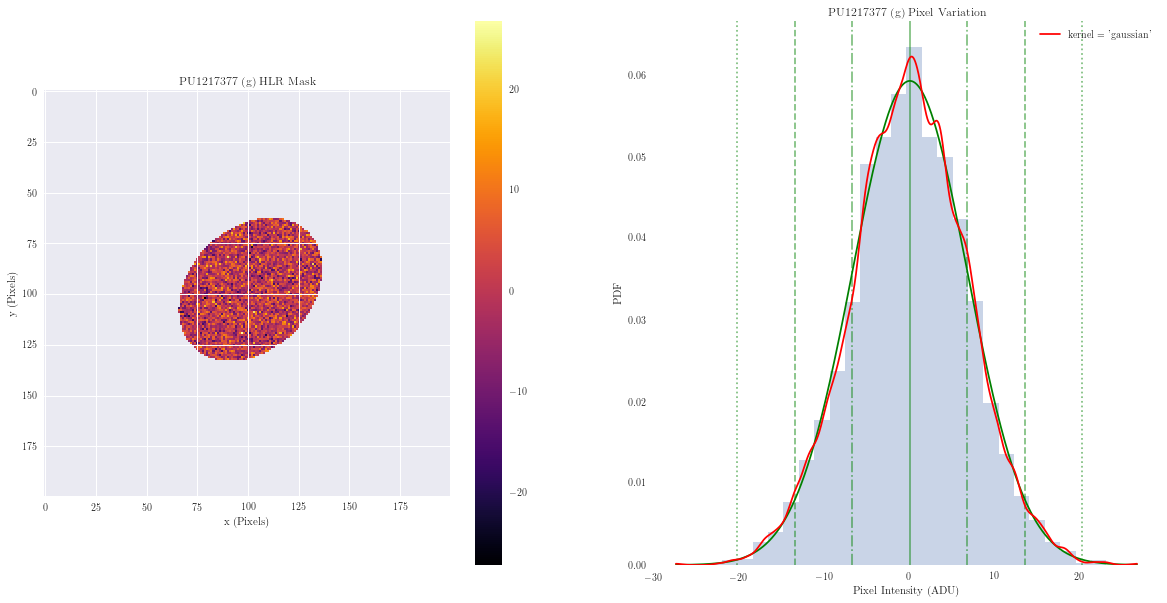

PU1217377 (g) 
	Background Mean:   164.827 ADU 
	Background StDev:  0.093 ADU 
	Galaxy Mean:       0.115 ADU 
	Galaxy Median:     0.134 ADU 
	Galaxy StDev:      6.736 ADU 
	Recessional Vel:   526.000 ADU 
	Mean Square Error: 3.263 ADU


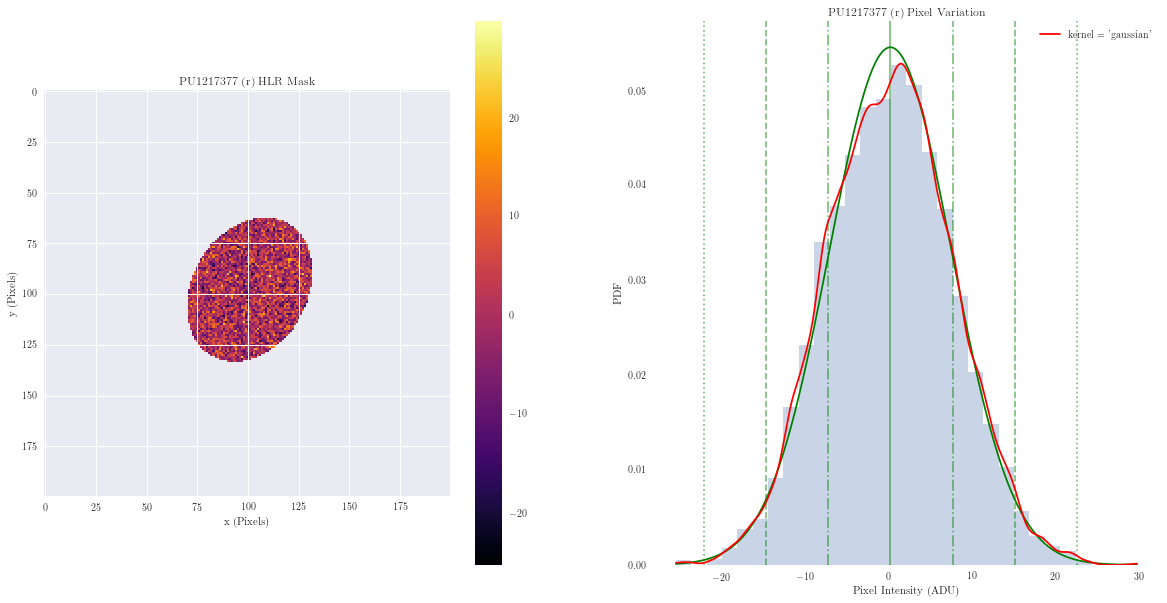

PU1217377 (r) 
	Background Mean:   201.131 ADU 
	Background StDev:  0.068 ADU 
	Galaxy Mean:       0.260 ADU 
	Galaxy Median:     0.326 ADU 
	Galaxy StDev:      7.316 ADU 
	Recessional Vel:   526.000 ADU 
	Mean Square Error: 2.399 ADU


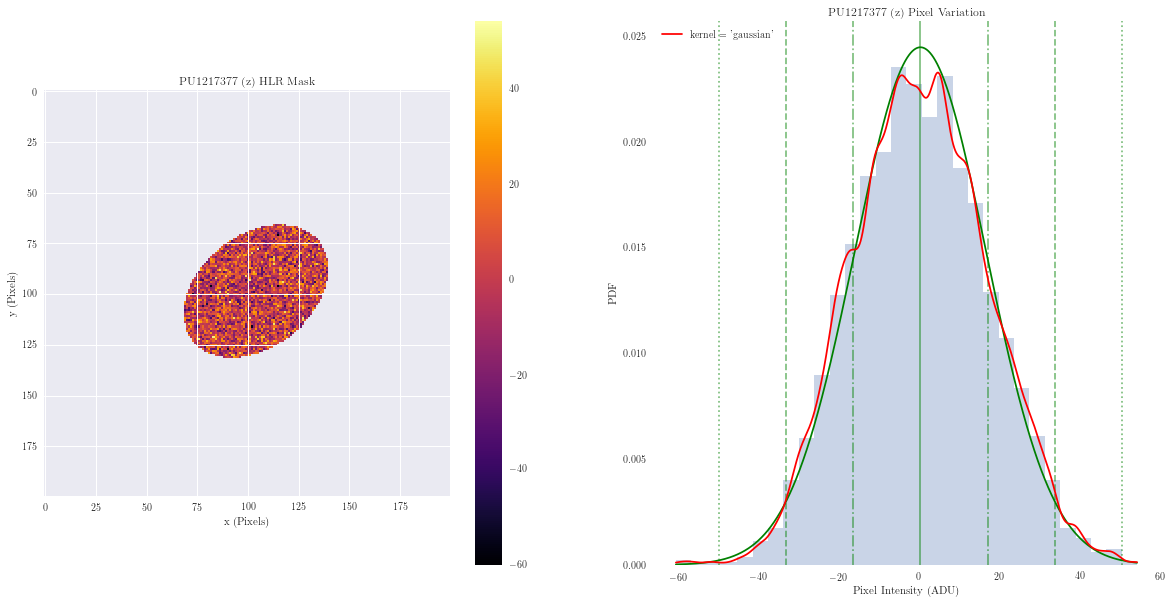

PU1217377 (z) 
	Background Mean:   2829.628 ADU 
	Background StDev:  0.120 ADU 
	Galaxy Mean:       0.428 ADU 
	Galaxy Median:     0.224 ADU 
	Galaxy StDev:      16.310 ADU 
	Recessional Vel:   526.000 ADU 
	Mean Square Error: 0.495 ADU


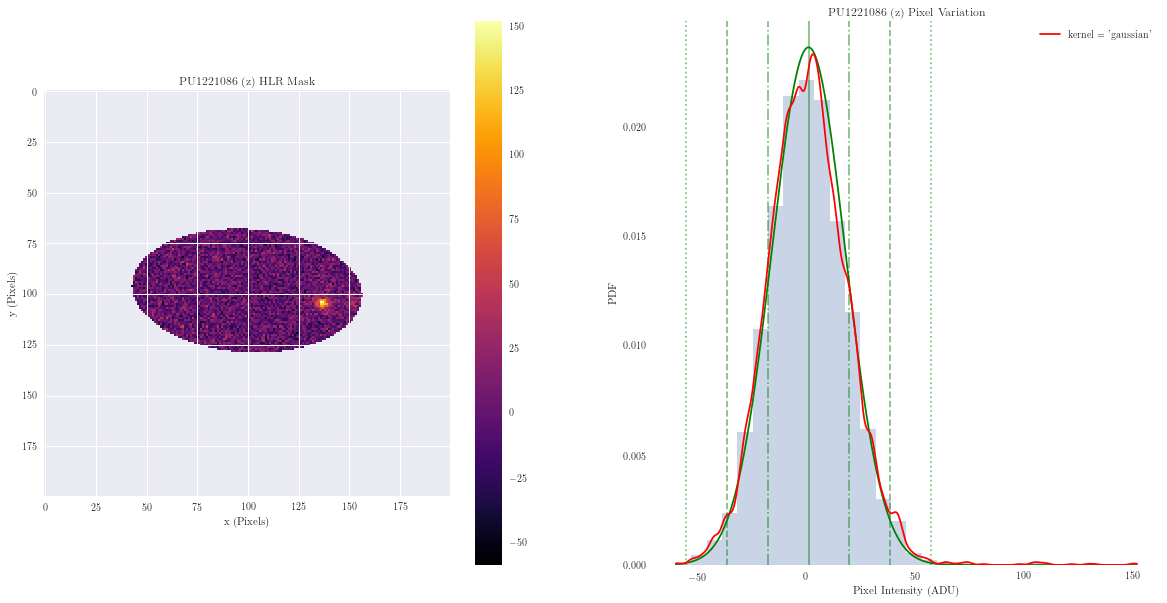

PU1221086 (z) 
	Background Mean:   3459.031 ADU 
	Background StDev:  0.370 ADU 
	Galaxy Mean:       1.372 ADU 
	Galaxy Median:     0.974 ADU 
	Galaxy StDev:      16.869 ADU 
	Recessional Vel:   1287.000 ADU 
	Mean Square Error: 0.592 ADU


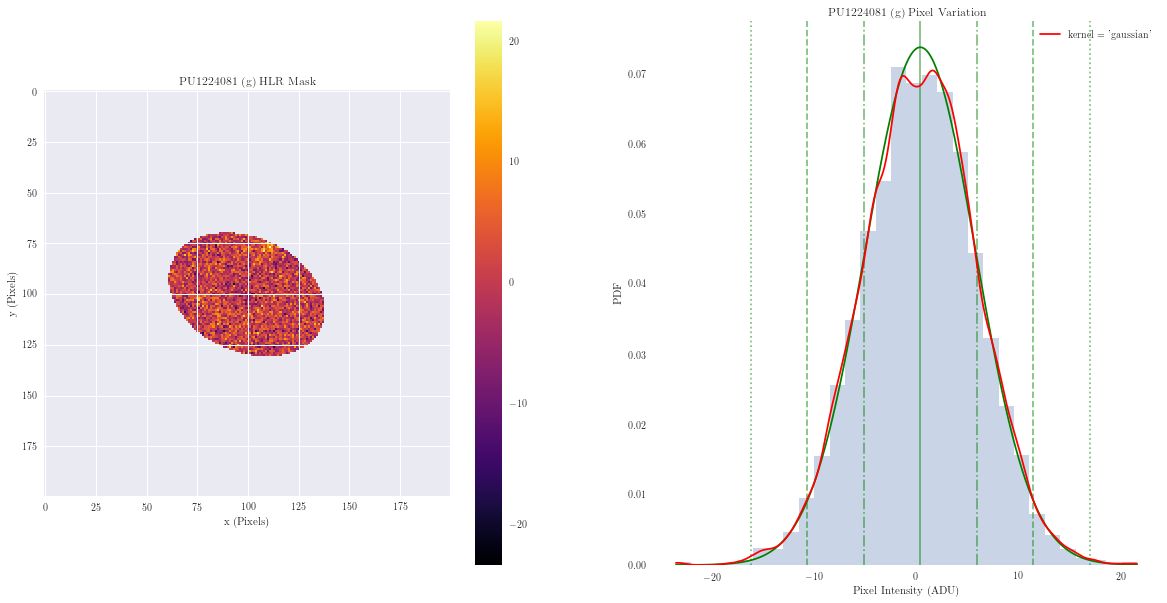

PU1224081 (g) 
	Background Mean:   171.654 ADU 
	Background StDev:  0.099 ADU 
	Galaxy Mean:       0.425 ADU 
	Galaxy Median:     0.482 ADU 
	Galaxy StDev:      5.409 ADU 
	Recessional Vel:   37.000 ADU 
	Mean Square Error: 4.637 ADU


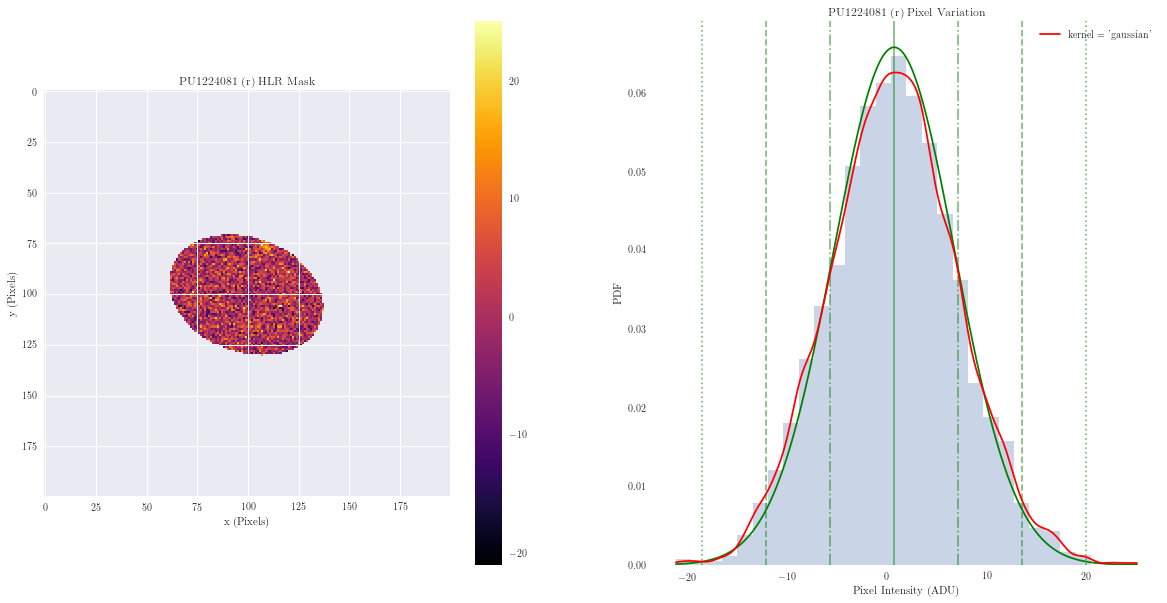

PU1224081 (r) 
	Background Mean:   264.633 ADU 
	Background StDev:  0.100 ADU 
	Galaxy Mean:       0.730 ADU 
	Galaxy Median:     0.681 ADU 
	Galaxy StDev:      6.064 ADU 
	Recessional Vel:   37.000 ADU 
	Mean Square Error: 3.516 ADU


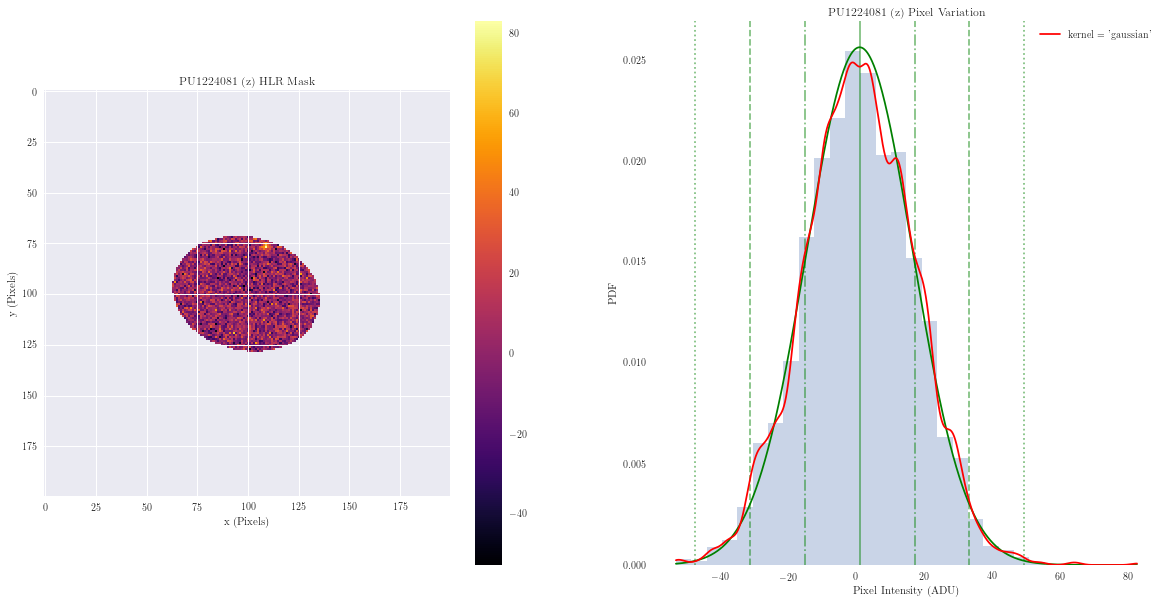

PU1224081 (z) 
	Background Mean:   2697.571 ADU 
	Background StDev:  0.126 ADU 
	Galaxy Mean:       1.133 ADU 
	Galaxy Median:     1.094 ADU 
	Galaxy StDev:      15.582 ADU 
	Recessional Vel:   37.000 ADU 
	Mean Square Error: 0.495 ADU


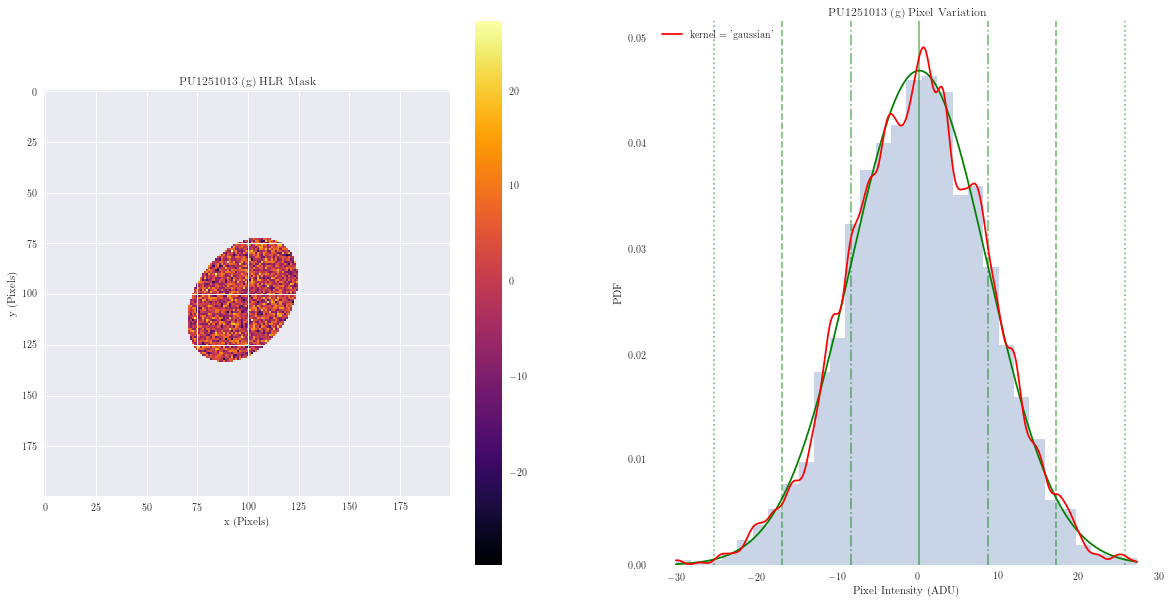

PU1251013 (g) 
	Background Mean:   129.377 ADU 
	Background StDev:  0.027 ADU 
	Galaxy Mean:       0.262 ADU 
	Galaxy Median:     0.353 ADU 
	Galaxy StDev:      8.501 ADU 
	Recessional Vel:   6159.000 ADU 
	Mean Square Error: 1.345 ADU


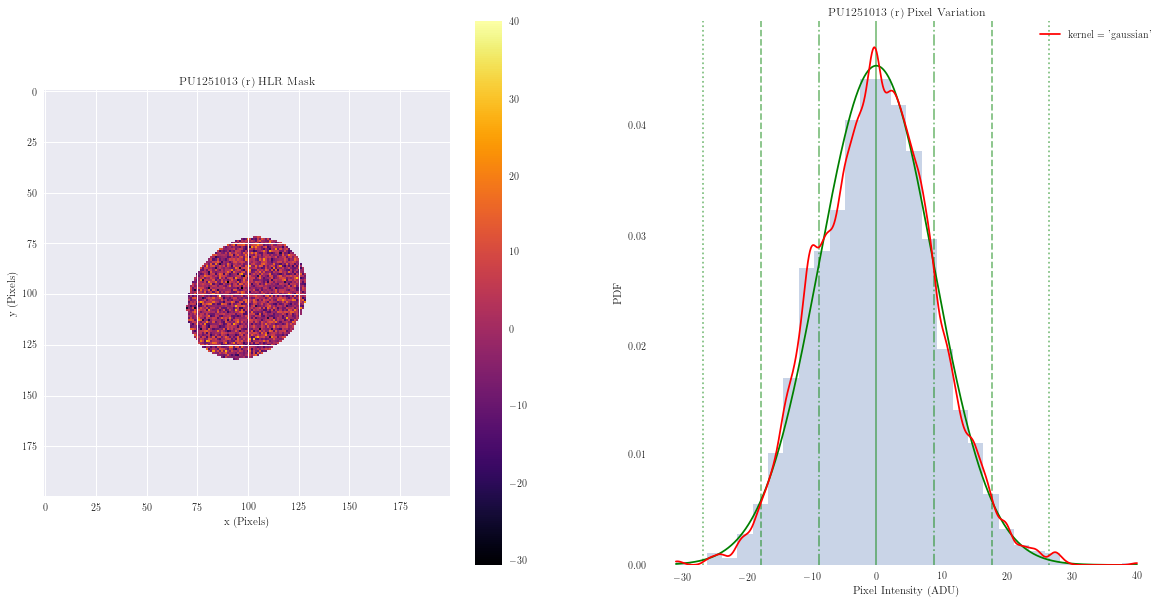

PU1251013 (r) 
	Background Mean:   149.314 ADU 
	Background StDev:  0.033 ADU 
	Galaxy Mean:       -0.029 ADU 
	Galaxy Median:     -0.072 ADU 
	Galaxy StDev:      8.774 ADU 
	Recessional Vel:   6159.000 ADU 
	Mean Square Error: 1.374 ADU


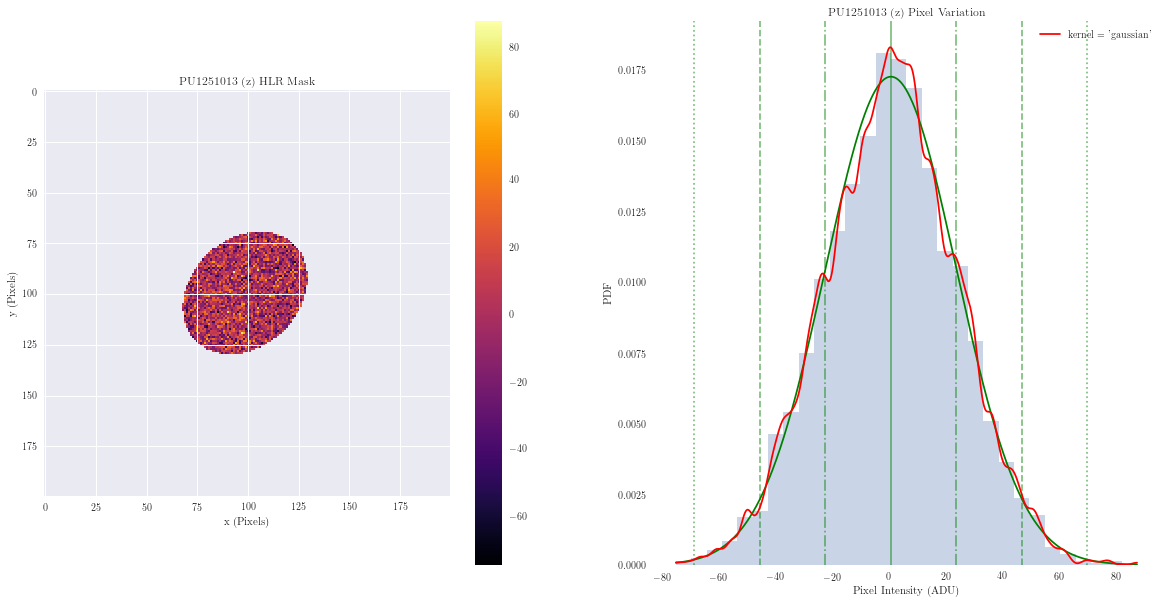

PU1251013 (z) 
	Background Mean:   5666.656 ADU 
	Background StDev:  0.116 ADU 
	Galaxy Mean:       0.781 ADU 
	Galaxy Median:     0.986 ADU 
	Galaxy StDev:      23.051 ADU 
	Recessional Vel:   6159.000 ADU 
	Mean Square Error: 0.211 ADU


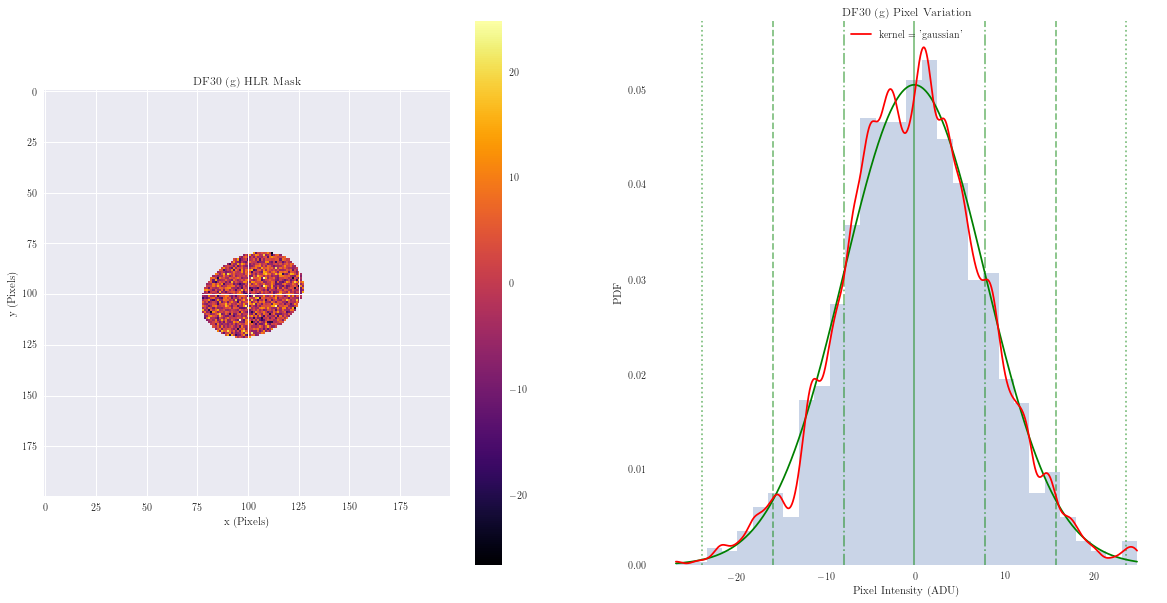

DF30 (g) 
	Background Mean:   220.425 ADU 
	Background StDev:  0.008 ADU 
	Galaxy Mean:       -0.091 ADU 
	Galaxy Median:     -0.091 ADU 
	Galaxy StDev:      7.891 ADU 
	Recessional Vel:   7316.000 ADU 
	Mean Square Error: 1.038 ADU


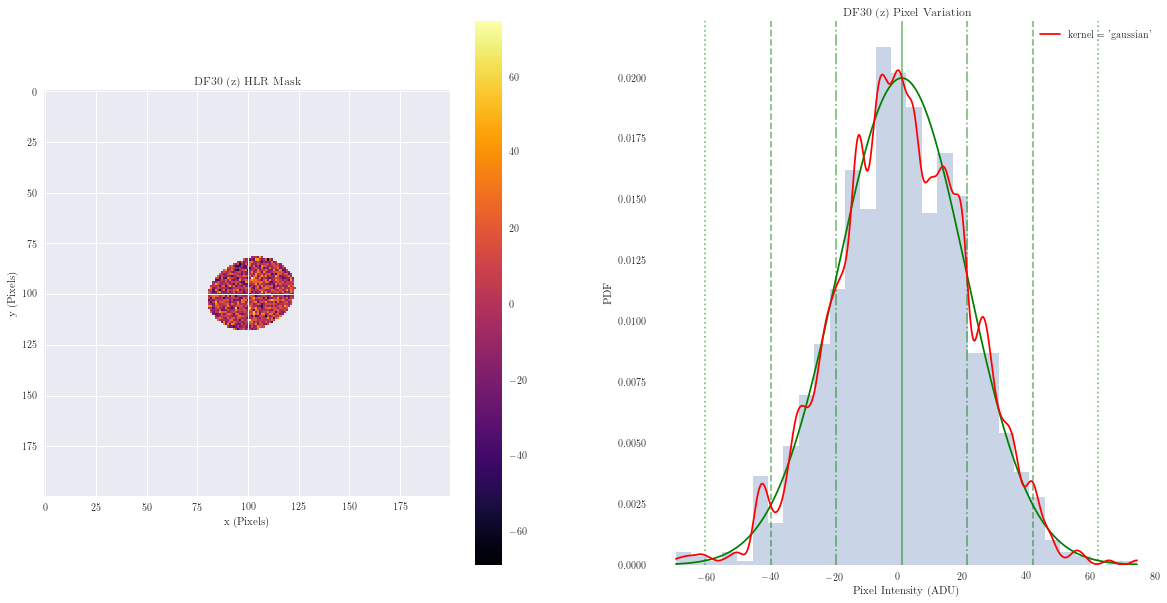

DF30 (z) 
	Background Mean:   5044.535 ADU 
	Background StDev:  0.007 ADU 
	Galaxy Mean:       1.227 ADU 
	Galaxy Median:     1.008 ADU 
	Galaxy StDev:      19.962 ADU 
	Recessional Vel:   7316.000 ADU 
	Mean Square Error: 0.117 ADU


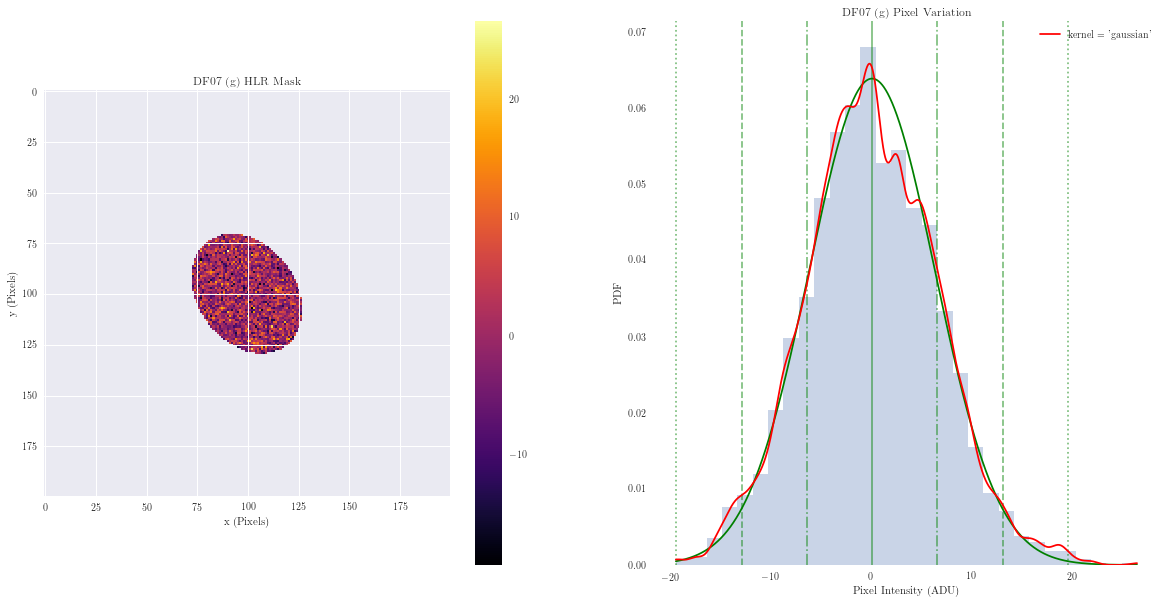

DF07 (g) 
	Background Mean:   144.948 ADU 
	Background StDev:  0.029 ADU 
	Galaxy Mean:       0.134 ADU 
	Galaxy Median:     -0.090 ADU 
	Galaxy StDev:      6.252 ADU 
	Recessional Vel:   6587.000 ADU 
	Mean Square Error: 2.382 ADU


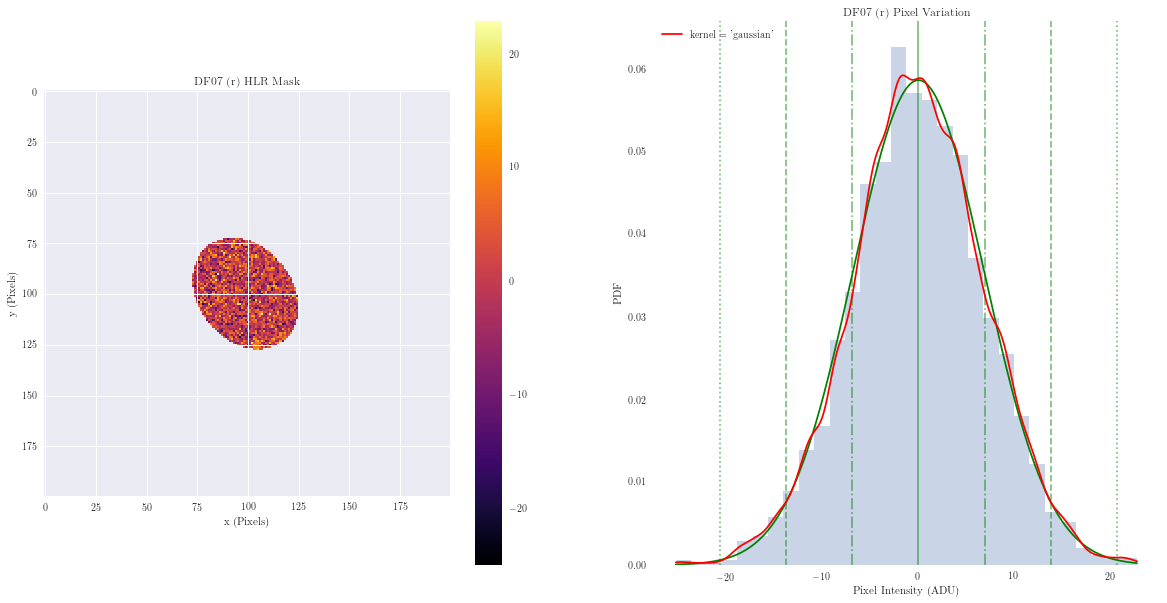

DF07 (r) 
	Background Mean:   168.509 ADU 
	Background StDev:  0.022 ADU 
	Galaxy Mean:       0.136 ADU 
	Galaxy Median:     0.108 ADU 
	Galaxy StDev:      6.811 ADU 
	Recessional Vel:   6587.000 ADU 
	Mean Square Error: 1.845 ADU


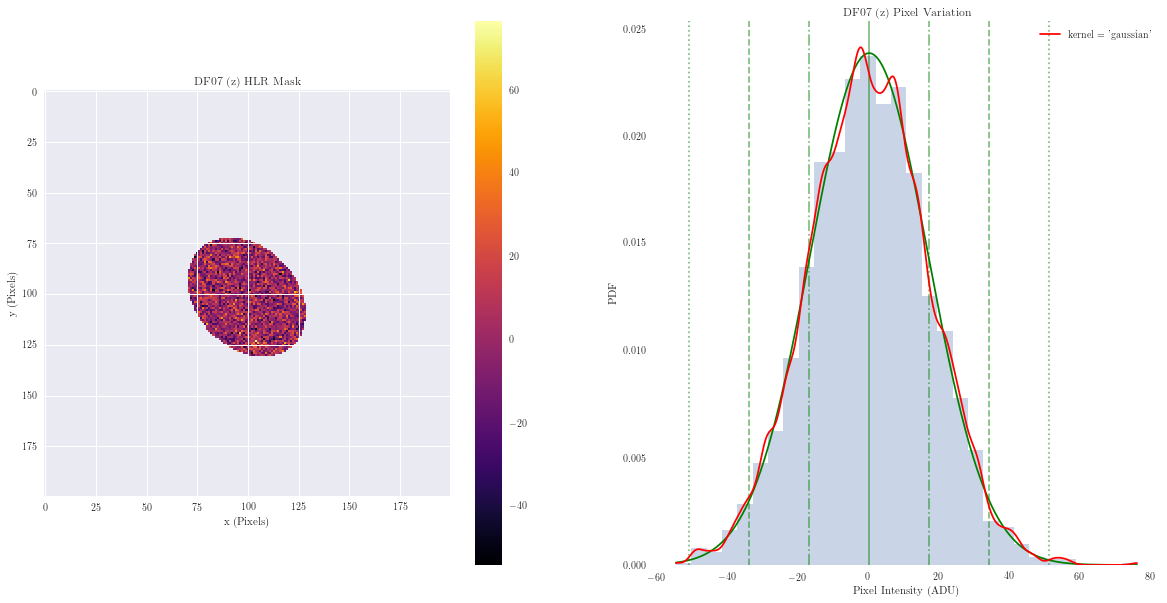

DF07 (z) 
	Background Mean:   3436.929 ADU 
	Background StDev:  0.084 ADU 
	Galaxy Mean:       0.414 ADU 
	Galaxy Median:     0.189 ADU 
	Galaxy StDev:      16.728 ADU 
	Recessional Vel:   6587.000 ADU 
	Mean Square Error: 0.356 ADU


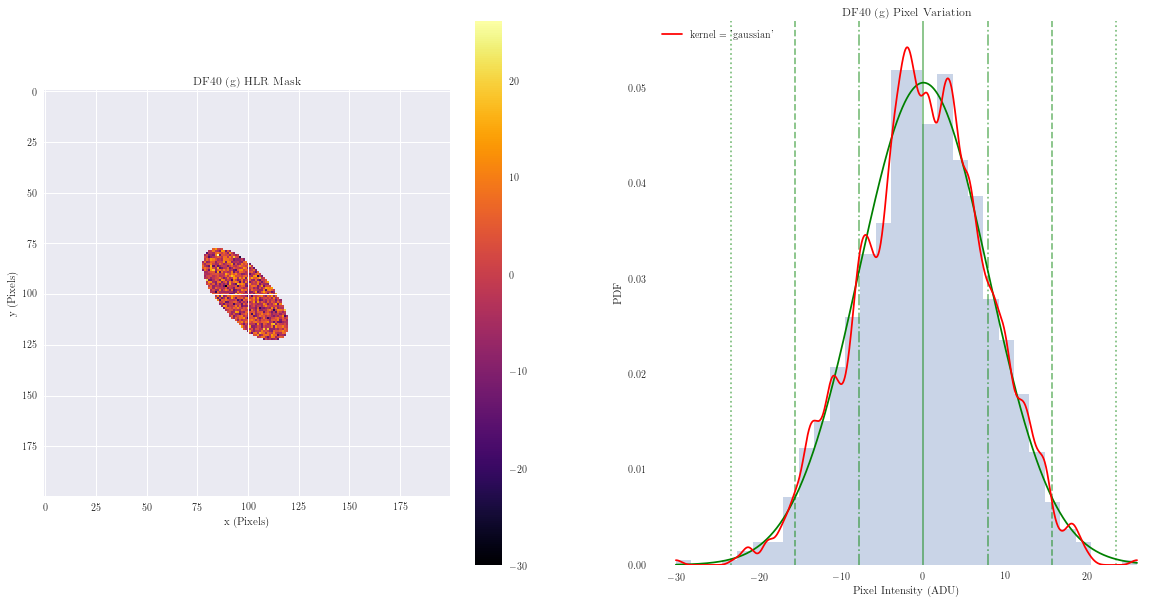

DF40 (g) 
	Background Mean:   219.770 ADU 
	Background StDev:  0.002 ADU 
	Galaxy Mean:       0.118 ADU 
	Galaxy Median:     0.185 ADU 
	Galaxy StDev:      7.892 ADU 
	Recessional Vel:   7792.000 ADU 
	Mean Square Error: 0.728 ADU


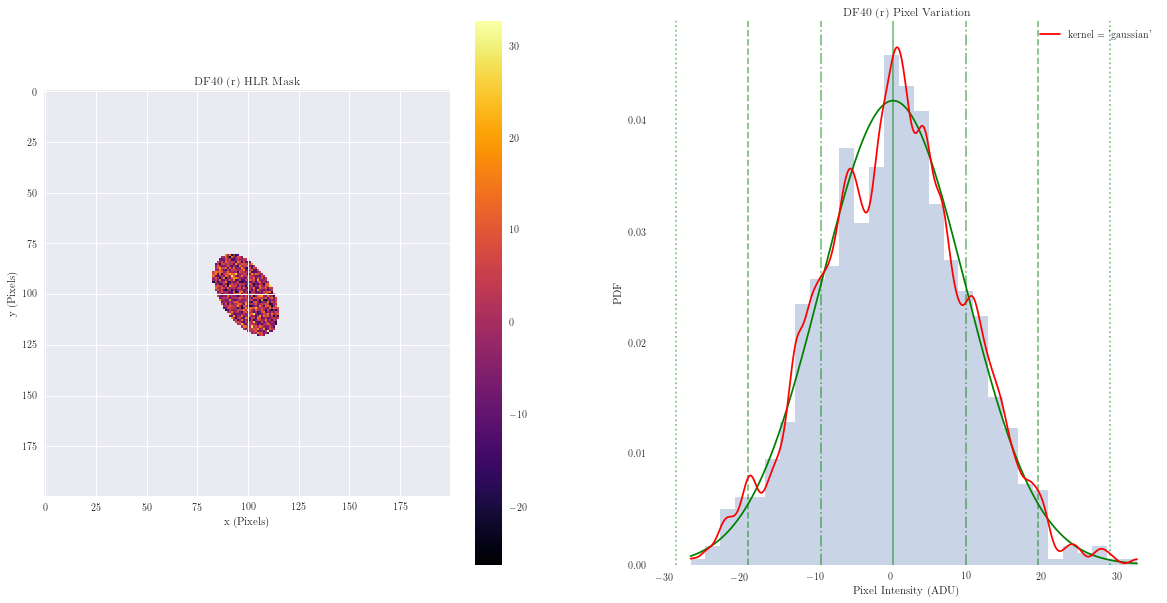

DF40 (r) 
	Background Mean:   497.810 ADU 
	Background StDev:  0.001 ADU 
	Galaxy Mean:       0.375 ADU 
	Galaxy Median:     0.541 ADU 
	Galaxy StDev:      9.535 ADU 
	Recessional Vel:   7792.000 ADU 
	Mean Square Error: 0.386 ADU


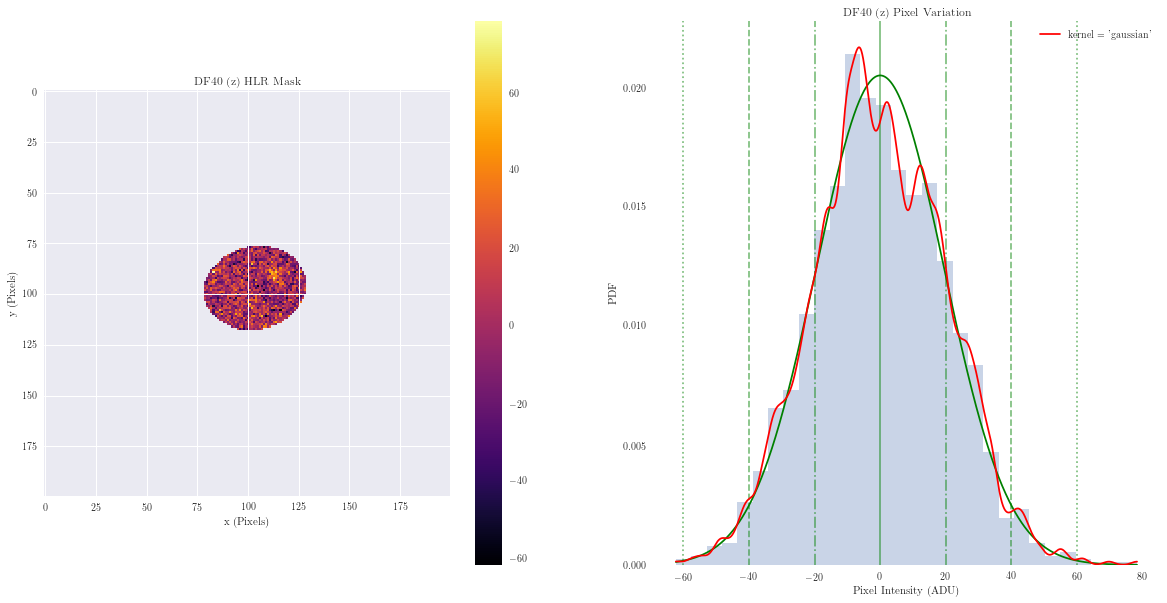

DF40 (z) 
	Background Mean:   4118.306 ADU 
	Background StDev:  0.010 ADU 
	Galaxy Mean:       0.211 ADU 
	Galaxy Median:     -0.509 ADU 
	Galaxy StDev:      19.460 ADU 
	Recessional Vel:   7792.000 ADU 
	Mean Square Error: 0.167 ADU


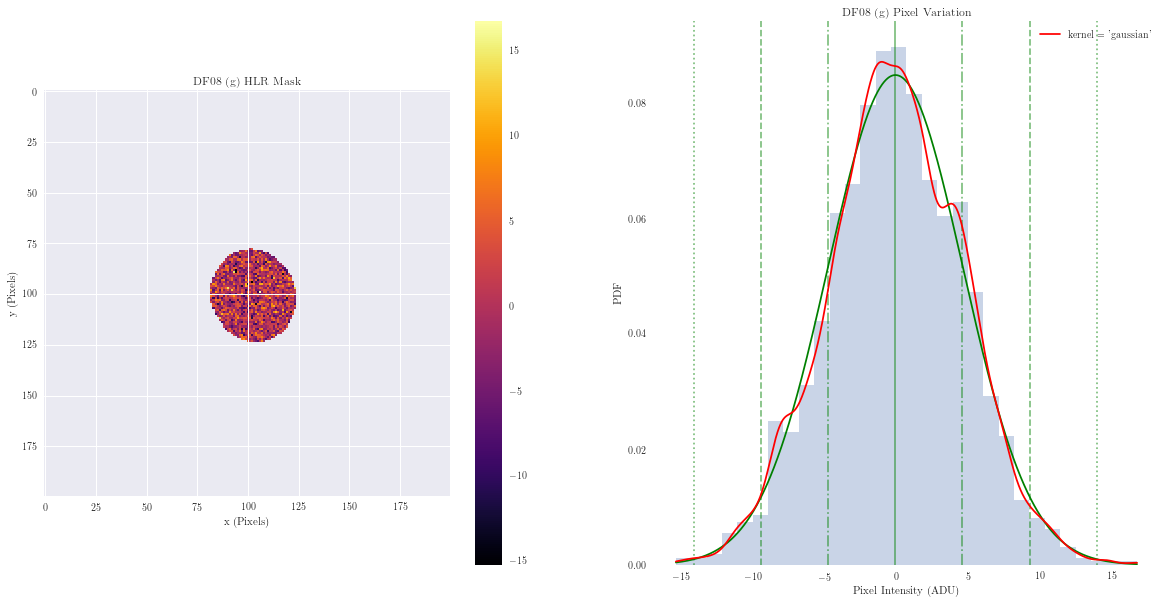

DF08 (g) 
	Background Mean:   163.990 ADU 
	Background StDev:  0.003 ADU 
	Galaxy Mean:       -0.053 ADU 
	Galaxy Median:     -0.057 ADU 
	Galaxy StDev:      4.700 ADU 
	Recessional Vel:   7051.000 ADU 
	Mean Square Error: 2.715 ADU


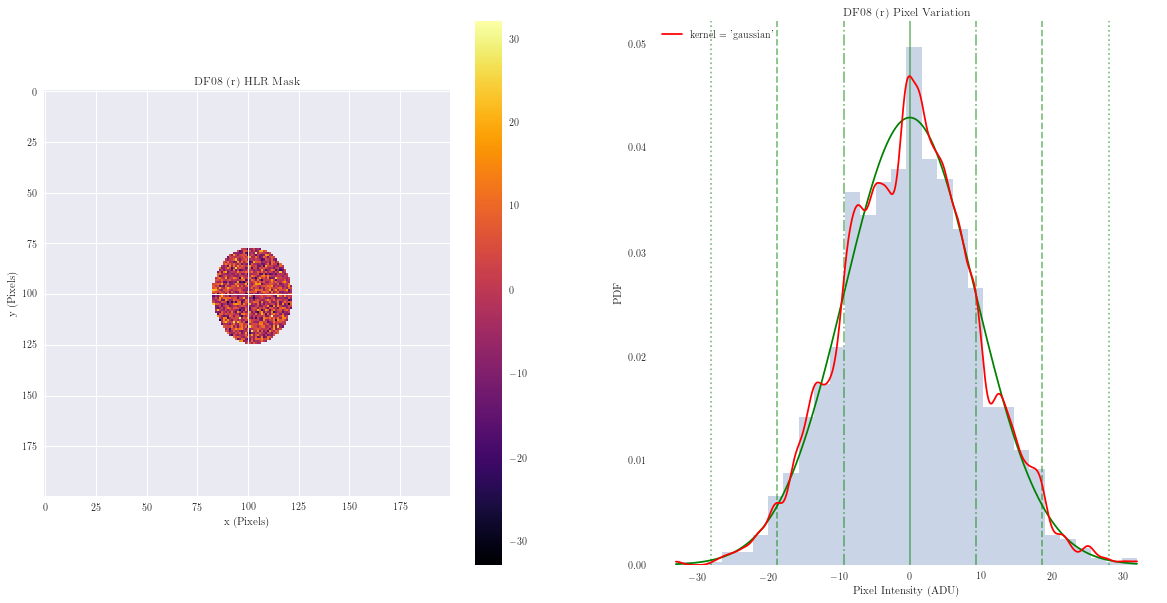

DF08 (r) 
	Background Mean:   504.347 ADU 
	Background StDev:  0.005 ADU 
	Galaxy Mean:       0.022 ADU 
	Galaxy Median:     0.006 ADU 
	Galaxy StDev:      9.294 ADU 
	Recessional Vel:   7051.000 ADU 
	Mean Square Error: 0.671 ADU


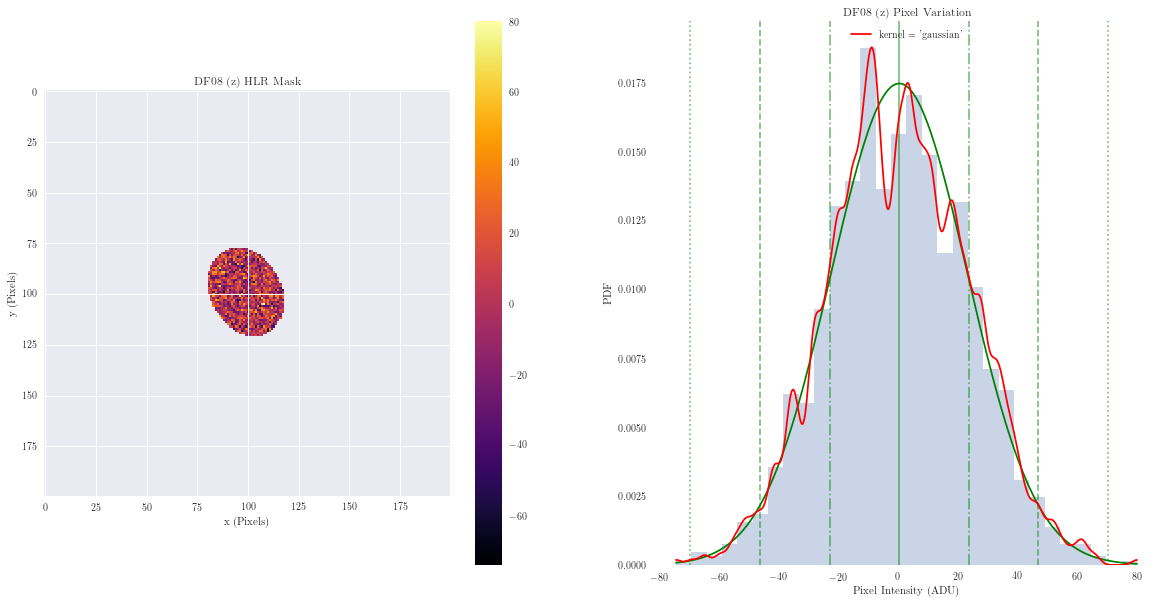

DF08 (z) 
	Background Mean:   5020.734 ADU 
	Background StDev:  0.003 ADU 
	Galaxy Mean:       0.510 ADU 
	Galaxy Median:     0.364 ADU 
	Galaxy StDev:      22.792 ADU 
	Recessional Vel:   7051.000 ADU 
	Mean Square Error: 0.093 ADU


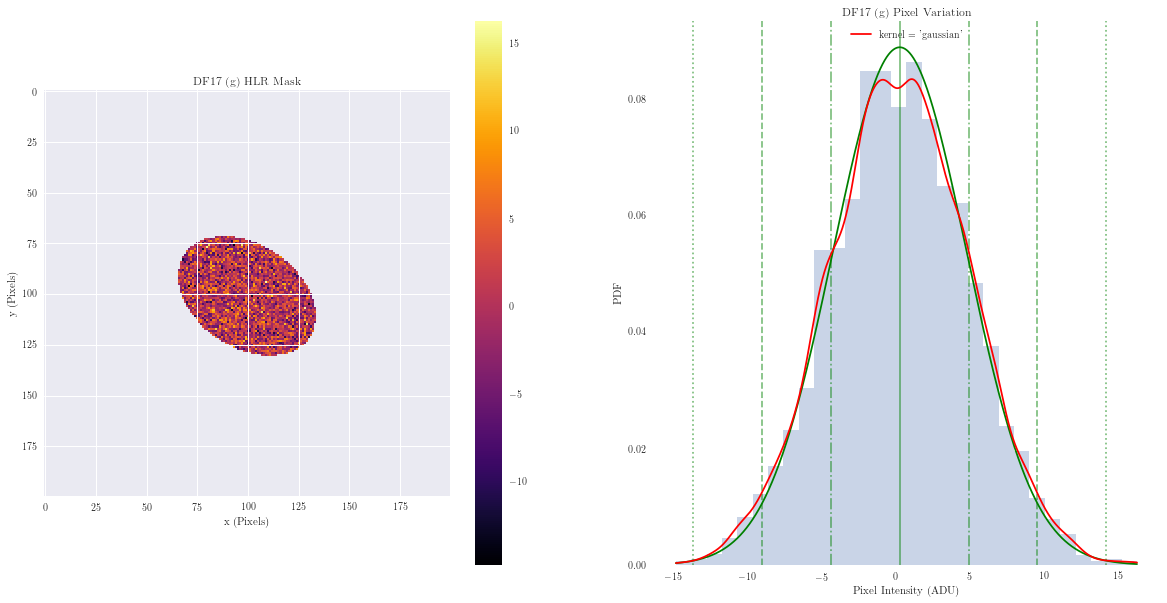

DF17 (g) 
	Background Mean:   163.954 ADU 
	Background StDev:  0.028 ADU 
	Galaxy Mean:       0.272 ADU 
	Galaxy Median:     0.310 ADU 
	Galaxy StDev:      4.495 ADU 
	Recessional Vel:   nan ADU 
	Mean Square Error: 5.549 ADU


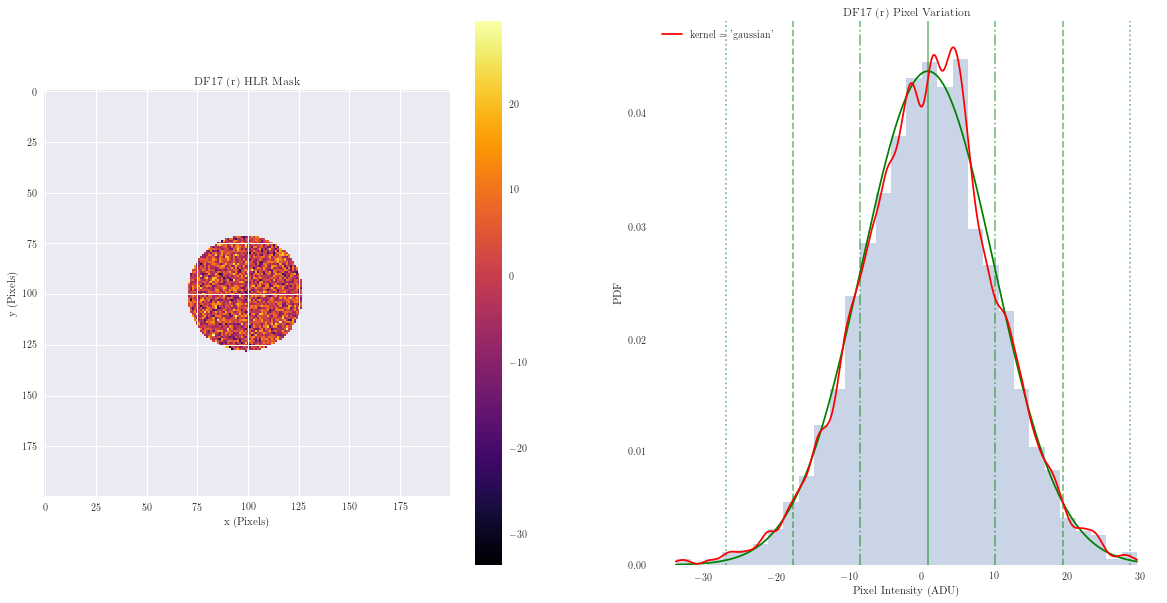

DF17 (r) 
	Background Mean:   504.189 ADU 
	Background StDev:  0.031 ADU 
	Galaxy Mean:       0.910 ADU 
	Galaxy Median:     1.198 ADU 
	Galaxy StDev:      9.116 ADU 
	Recessional Vel:   nan ADU 
	Mean Square Error: 1.206 ADU


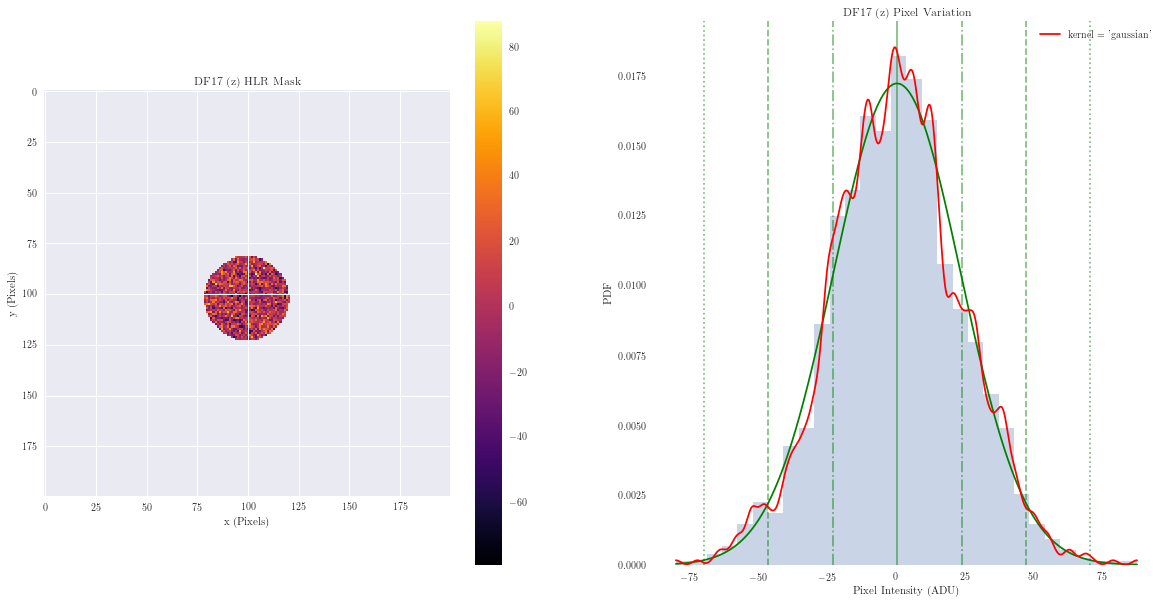

DF17 (z) 
	Background Mean:   5018.648 ADU 
	Background StDev:  0.007 ADU 
	Galaxy Mean:       0.486 ADU 
	Galaxy Median:     0.473 ADU 
	Galaxy StDev:      23.118 ADU 
	Recessional Vel:   nan ADU 
	Mean Square Error: 0.101 ADU


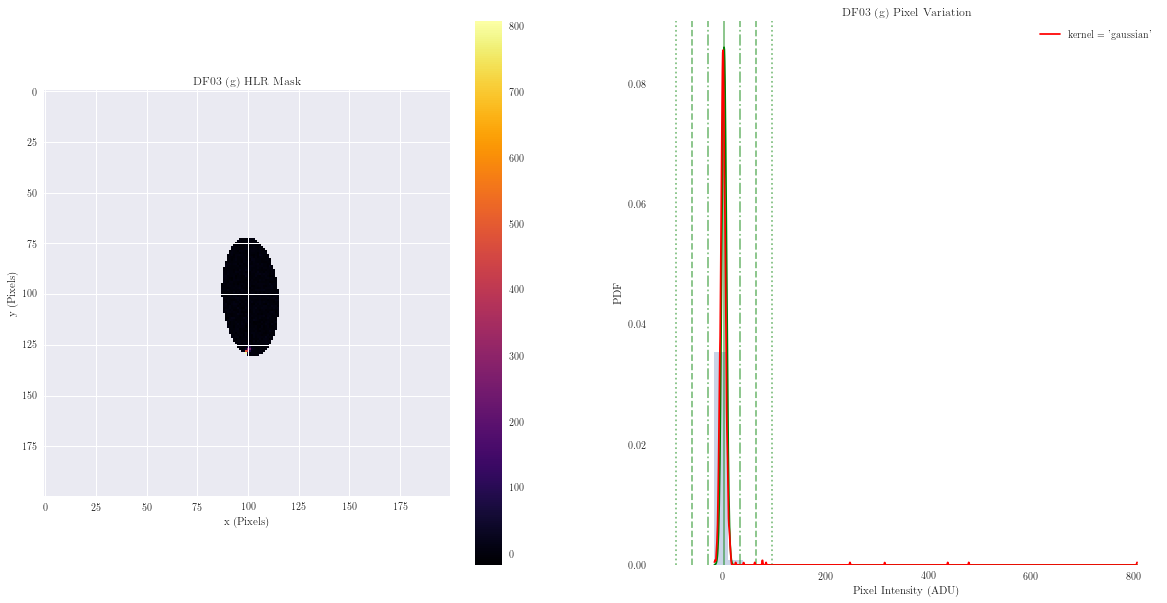

DF03 (g) 
	Background Mean:   164.189 ADU 
	Background StDev:  0.001 ADU 
	Galaxy Mean:       2.603 ADU 
	Galaxy Median:     0.540 ADU 
	Galaxy StDev:      4.631 ADU 
	Recessional Vel:   10150.000 ADU 
	Mean Square Error: 0.182 ADU


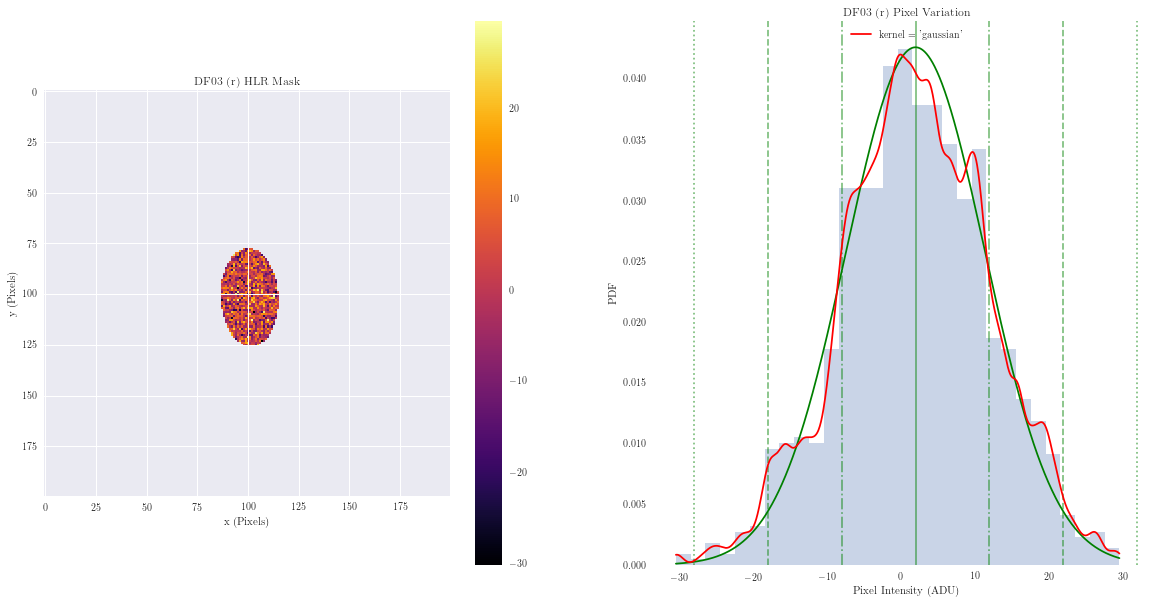

DF03 (r) 
	Background Mean:   504.322 ADU 
	Background StDev:  0.001 ADU 
	Galaxy Mean:       1.992 ADU 
	Galaxy Median:     1.973 ADU 
	Galaxy StDev:      9.365 ADU 
	Recessional Vel:   10150.000 ADU 
	Mean Square Error: 0.465 ADU


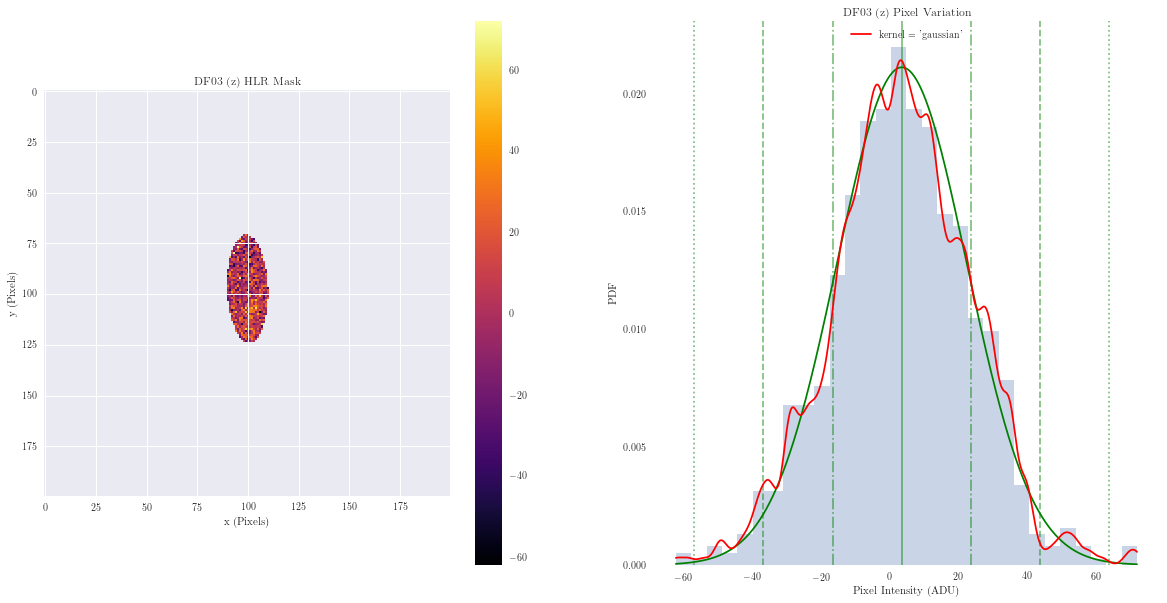

DF03 (z) 
	Background Mean:   4755.168 ADU 
	Background StDev:  0.000 ADU 
	Galaxy Mean:       3.598 ADU 
	Galaxy Median:     3.557 ADU 
	Galaxy StDev:      18.878 ADU 
	Recessional Vel:   10150.000 ADU 
	Mean Square Error: 0.091 ADU


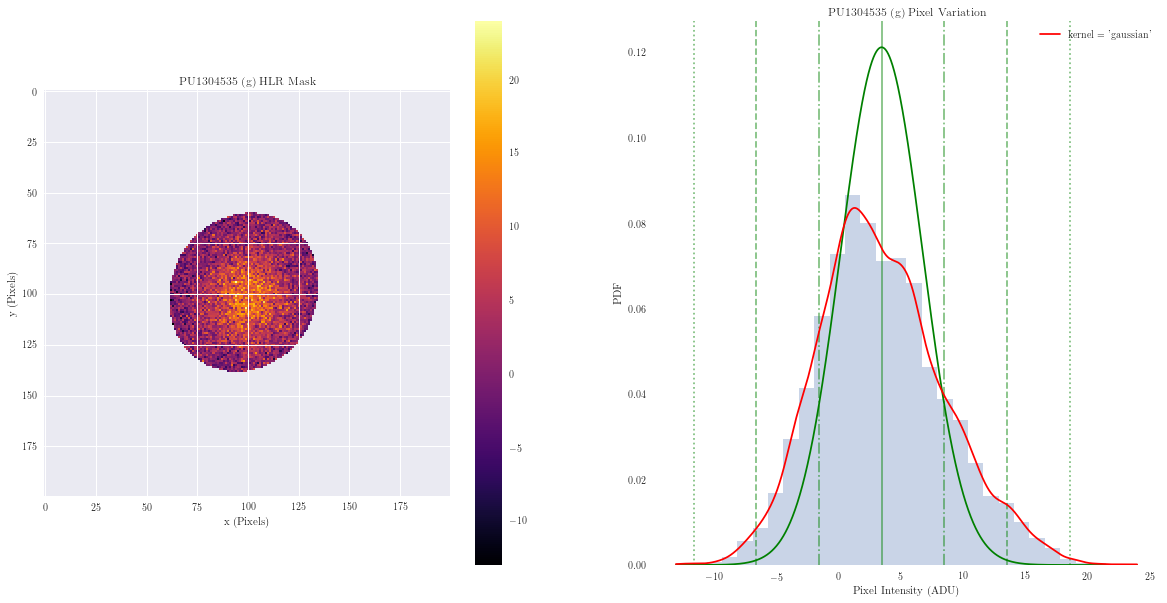

PU1304535 (g) 
	Background Mean:   183.055 ADU 
	Background StDev:  0.156 ADU 
	Galaxy Mean:       3.465 ADU 
	Galaxy Median:     3.015 ADU 
	Galaxy StDev:      3.287 ADU 
	Recessional Vel:   7333.000 ADU 
	Mean Square Error: 10.812 ADU


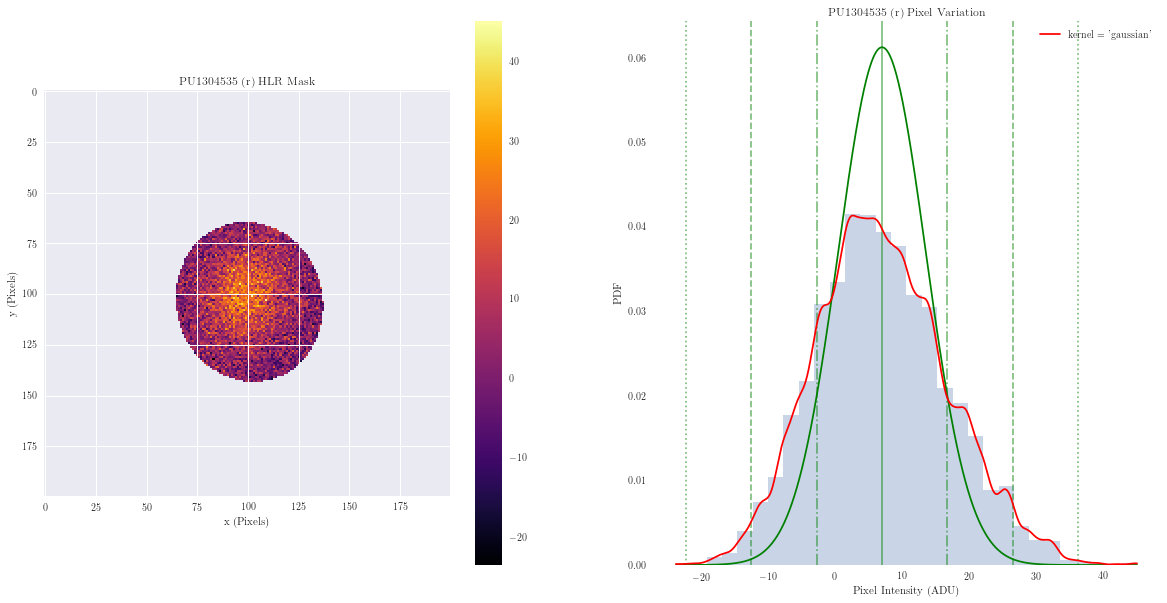

PU1304535 (r) 
	Background Mean:   551.694 ADU 
	Background StDev:  0.233 ADU 
	Galaxy Mean:       7.046 ADU 
	Galaxy Median:     6.488 ADU 
	Galaxy StDev:      6.519 ADU 
	Recessional Vel:   7333.000 ADU 
	Mean Square Error: 2.819 ADU


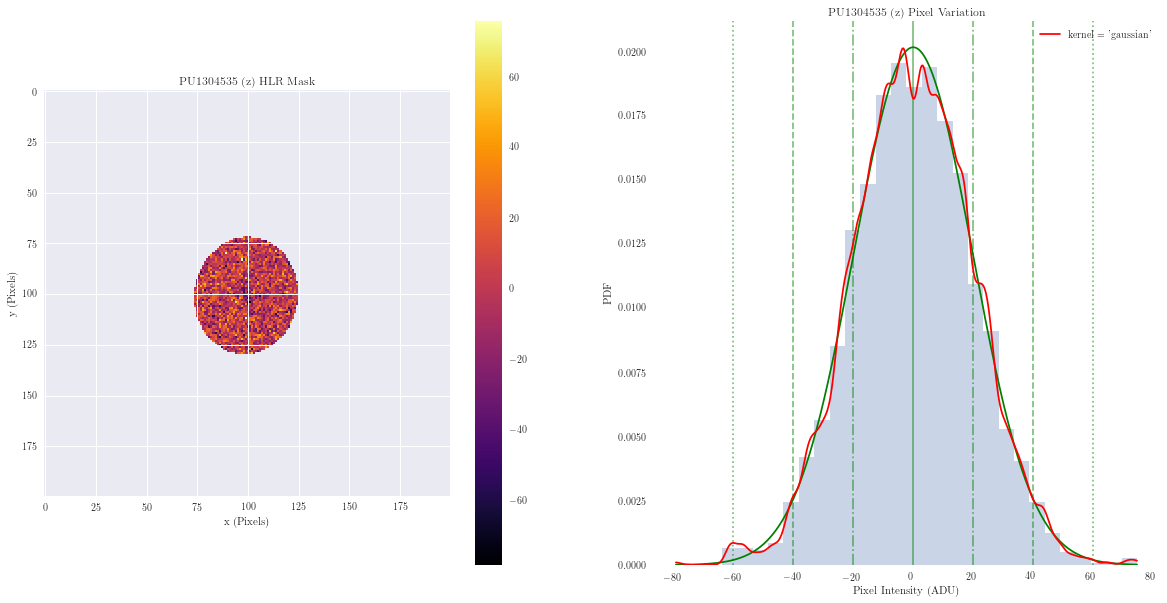

PU1304535 (z) 
	Background Mean:   4608.827 ADU 
	Background StDev:  0.122 ADU 
	Galaxy Mean:       0.795 ADU 
	Galaxy Median:     0.540 ADU 
	Galaxy StDev:      19.786 ADU 
	Recessional Vel:   7333.000 ADU 
	Mean Square Error: 0.230 ADU


In [62]:
for obs in obs_list:
    
    data = fits.getdata(obs.get_res())
    mask = fits.getdata(obs.get_mask()) > 0.5
    
    obs.kde = plot_kde(data, mask=mask, band=obs.band, background=(obs.bkg_mean, obs.bkg_stdev), file=obs.get_basename() + kde_ext + png_file)
    obs.mse = set_mse(obs)
    
    print("{0} ({1})".format(obs.name, obs.band),
          "\n\tBackground Mean:   %.3f ADU" % obs.bkg_mean,
          "\n\tBackground StDev:  %.3f ADU" % obs.bkg_stdev,
          "\n\tGalaxy Mean:       %.3f ADU" % obs.gal_mean,
          "\n\tGalaxy Median:     %.3f ADU" % obs.gal_median,
          "\n\tGalaxy StDev:      %.3f ADU" % obs.gal_stdev,
          "\n\tRecessional Vel:   %.3f ADU" % obs.velocity,
          "\n\tMean Square Error: %.3f ADU" % obs.mse)    



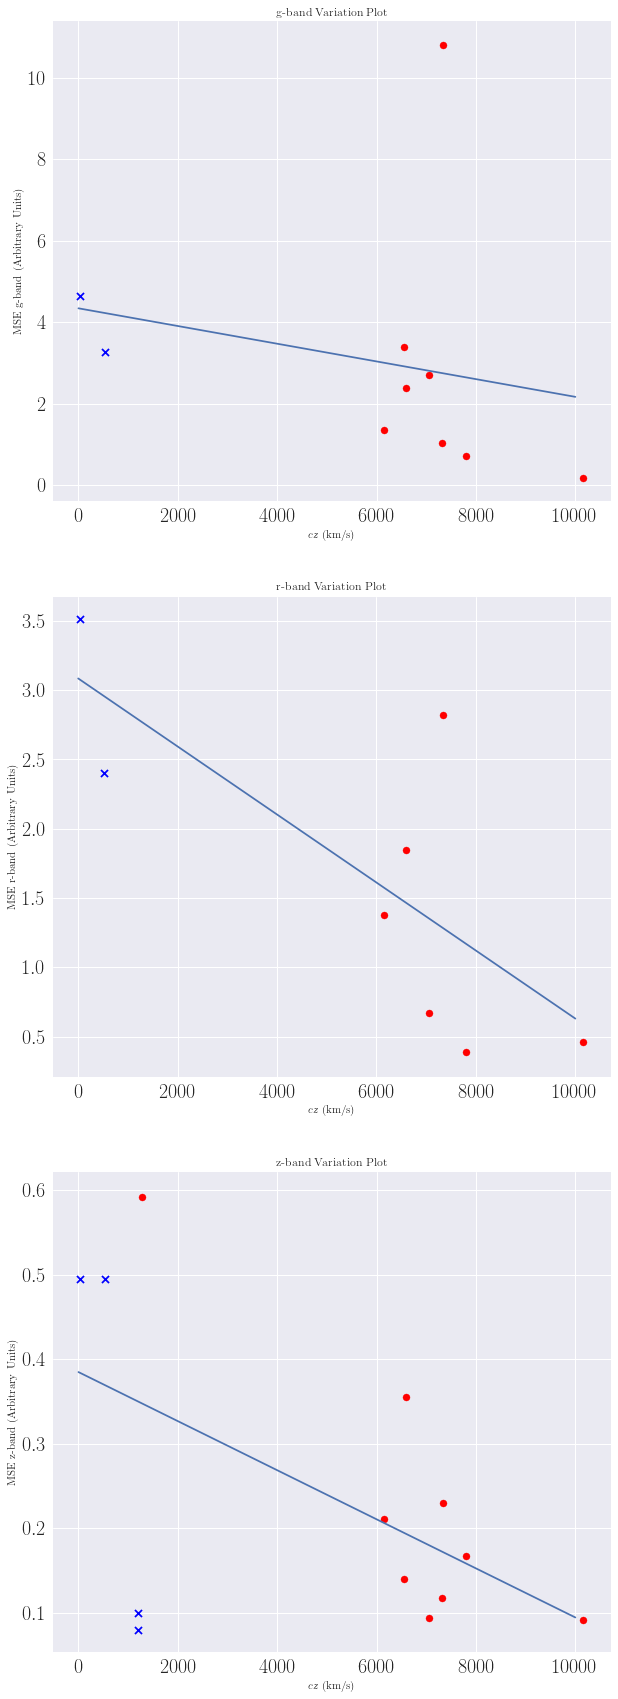

In [63]:
plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)


fig = plt.figure(figsize=(10,30))
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

plot_list = [(ax1,'g'), (ax2,'r'), (ax3,'z')]
velocity  = np.linspace(0,10000,10)

for ax,band in plot_list:
    data  = [(obs.velocity, obs.mse, obs.radius_eff) for obs in obs_list if obs.velocity is not np.nan if band in obs.band]
    
    x,y,r = np.array(data).T
    
    ax.set_title("{0}-band Variation Plot".format(band))
    ax.set_xlabel(r"$cz$ (km/s)")
    ax.set_ylabel(r"MSE {0}-band (Arbitrary Units)".format(band))
    
    s = 50
    c = ['r' if item else 'b' for item in r > UDG_RADIUS]
    m = ['o' if item else 'x' for item in r > UDG_RADIUS]   
    
    for idx in np.arange(x.size):
        ax.scatter(x[idx], y[idx], color=c[idx], s=s, marker=m[idx])
    
    m,b = np.polyfit(x, y, 1)
    pred = m * velocity + b
    ax.plot(velocity, pred)
    
plt.show()
plt.close()


# Discussion & Future Work

The plots above show the distribution of MSE given each wavelength (g-, r-, z-bands, respectively) for the true UDGs (red dots) and the spurious sources (blue crossmarks) for which we've attained spectroscopic redshifts. We must be careful when interpreting these results due to the lack of spurious sources in our data set and due to the high scatter around the best-fit line. However, in general, our contaminants have higher MSEs compared to the UDGs in our sample. This work shows promising preliminary results, suggesting that pixel variations can be used to determine the likelihood of the candidate being a true UDG.

In the future, I would like to implement the following:
1. Use cross-validation to more rigorously determine the appropriate bandwidth of KDE.
2. Acquire more LSB objects with spectroscopic redshifts to better constrain the fit.
3. Implement support vector machines to determine the thresholds separating UDGs from contaminants, given a the angular size of the object.